Ссылка на презентацию :  https://disk.yandex.ru/i/bRHWU0n75KX5jA

# E-commerce — Выявление профилей потребления

**Задача:
cегментировать покупателей по профилю потребления для формирования персонализированных предложений.**

Датасет описывает транзакции интернет-магазина товаров для дома и быта «Пока все ещё тут».

Колонки в  *ecommerce_dataset.csv* :

- `date` — дата заказа;
- `customer_id` — идентификатор покупателя;
- `order_id` — идентификатор заказа;
- `product` — наименование товара;
- `quantity` — количество товара в заказе;
- `price` — цена товара.

## Загрузка и изучение общей информации.

Импортируем библиотеки, сохраняем датасет в переменную *data*

In [1]:
!pip install wordcloud

In [2]:
import pandas as pd
import datetime as dt
import numpy as np 
from scipy import stats as st
import seaborn as sns
import matplotlib.pyplot as plt
import plotly.express as px 
%matplotlib inline

import re
from plotly import graph_objects as go
from wordcloud import WordCloud, STOPWORDS
from nltk.corpus import stopwords
from string import punctuation
russian_stopwords = stopwords.words("russian")
from pymystem3 import Mystem
from itertools import combinations
from collections import Counter
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from sklearn.datasets import make_blobs
from sklearn.metrics import silhouette_score
from scipy.cluster.hierarchy import dendrogram, linkage
from sklearn.cluster import AgglomerativeClustering
import plotly.offline as py
from plotly.offline import init_notebook_mode, iplot
from plotly import tools
init_notebook_mode(connected = True)
import plotly.figure_factory as ff

In [3]:
    try:
        data = pd.read_csv('D:\DOWNLOAD\ecommerce_dataset.csv')
    except:
        data = pd.read_csv ('/datasets/ecommerce_dataset.csv')
    

In [4]:
data.head()

,date,customer_id,order_id,product,quantity,price
0,2018100100,ee47d746-6d2f-4d3c-9622-c31412542920,68477,"Комнатное растение в горшке Алое Вера, d12, h30",1,142.0
1,2018100100,ee47d746-6d2f-4d3c-9622-c31412542920,68477,"Комнатное растение в горшке Кофе Арабика, d12,...",1,194.0
2,2018100100,ee47d746-6d2f-4d3c-9622-c31412542920,68477,Радермахера d-12 см h-20 см,1,112.0
3,2018100100,ee47d746-6d2f-4d3c-9622-c31412542920,68477,Хризолидокарпус Лутесценс d-9 см,1,179.0
4,2018100100,ee47d746-6d2f-4d3c-9622-c31412542920,68477,Циперус Зумула d-12 см h-25 см,1,112.0


In [5]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6737 entries, 0 to 6736
Data columns (total 6 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   date         6737 non-null   int64  
 1   customer_id  6737 non-null   object 
 2   order_id     6737 non-null   int64  
 3   product      6737 non-null   object 
 4   quantity     6737 non-null   int64  
 5   price        6737 non-null   float64
dtypes: float64(1), int64(3), object(2)
memory usage: 315.9+ KB


In [6]:
data.describe()

,date,order_id,quantity,price
count,6.737000e+03,6737.000000,6737.000000,6737.000000
mean,2.018855e+09,43128.948345,2.501559,462.028499
std,3.855185e+05,27899.414662,15.266478,871.296064
min,2.018100e+09,12624.000000,1.000000,9.000000
25%,2.019020e+09,14827.000000,1.000000,101.000000
50%,2.019050e+09,68503.000000,1.000000,135.000000
75%,2.019061e+09,70504.000000,1.000000,398.000000
max,2.019103e+09,73164.000000,1000.000000,14917.000000


Из общей информации видим, что столбец *date* в неверном формате, 6737 строчек, данные без пропусков, есть аномальные значения по столбцу с количеством товара в заказе и по стоимости товара.

## Предобработка данных.

### Проверим каждый столбец на наличие явных дубликатов, пропусков или нулей.

In [7]:
data.isnull().any()

date           False
customer_id    False
order_id       False
product        False
quantity       False
price          False
dtype: bool

In [8]:
data.duplicated().sum()

0

Явные дубликаты и нули отсутствуют.

### Проверим на неявные дубликаты, исключив столбец *date*

In [9]:
data[['customer_id','order_id','product','quantity','price']].duplicated().sum()

1864

In [10]:
clean_data = data[['customer_id','order_id','product','quantity','price']].drop_duplicates()

In [11]:
clean_data.head()

,customer_id,order_id,product,quantity,price
0,ee47d746-6d2f-4d3c-9622-c31412542920,68477,"Комнатное растение в горшке Алое Вера, d12, h30",1,142.0
1,ee47d746-6d2f-4d3c-9622-c31412542920,68477,"Комнатное растение в горшке Кофе Арабика, d12,...",1,194.0
2,ee47d746-6d2f-4d3c-9622-c31412542920,68477,Радермахера d-12 см h-20 см,1,112.0
3,ee47d746-6d2f-4d3c-9622-c31412542920,68477,Хризолидокарпус Лутесценс d-9 см,1,179.0
4,ee47d746-6d2f-4d3c-9622-c31412542920,68477,Циперус Зумула d-12 см h-25 см,1,112.0


In [12]:
clean_data = clean_data.join(data['date']).reset_index().drop(columns=['index'])
clean_data.head()

,customer_id,order_id,product,quantity,price,date
0,ee47d746-6d2f-4d3c-9622-c31412542920,68477,"Комнатное растение в горшке Алое Вера, d12, h30",1,142.0,2018100100
1,ee47d746-6d2f-4d3c-9622-c31412542920,68477,"Комнатное растение в горшке Кофе Арабика, d12,...",1,194.0,2018100100
2,ee47d746-6d2f-4d3c-9622-c31412542920,68477,Радермахера d-12 см h-20 см,1,112.0,2018100100
3,ee47d746-6d2f-4d3c-9622-c31412542920,68477,Хризолидокарпус Лутесценс d-9 см,1,179.0,2018100100
4,ee47d746-6d2f-4d3c-9622-c31412542920,68477,Циперус Зумула d-12 см h-25 см,1,112.0,2018100100


Проверим, нет ли заказов с одинаковым ID, относящихся к разным покупателям.

In [13]:
list_orders = clean_data.groupby('order_id').agg({'customer_id':'nunique'}).reset_index().query('customer_id > 1')['order_id']
list_orders.count()

29

Обнаружили 29 заказов с одинаковым ID, которые относятся к разным покупателям. Определить какую именно строку оставлять невозможно, поэтому удалим как ошибку в данных.

In [14]:
clean_data = clean_data.query('order_id not in @list_orders').reset_index().drop(columns=['index'])
clean_data.tail(10)

,customer_id,order_id,product,quantity,price,date
4797,7bd75579-e672-439a-9a55-e2a7072b5466,73146,Фиалка d-9 см синяя с белым рифленая,1,119.0,2019103018
4798,ff0c73c3-6b62-4e67-8e12-bb83ed1851d5,73147,Сушилка для белья на ванну FREUDENBERG (GIMI) ...,1,899.0,2019103019
4799,cb65d08a-dae7-4890-aef0-bb9f79055e02,73148,Каланхое каландива малиновое d-7 см,1,127.0,2019103021
4800,b24b3075-bbb5-498c-add9-534a727f3c33,73151,Герань домашняя (пеларгония зональная) цветуща...,2,157.0,2019103021
4801,6ddd4081-515e-401a-9567-8c0eab6dc868,73154,Литопс Микс d-5 см,1,112.0,2019103109
4802,f17ed857-178e-45e1-a662-0a9dd3b58c5f,73155,Мимоза стыдливая d-9 см,1,329.0,2019103111
4803,73d1cd35-5e5f-4629-8cf2-3fda829d4e58,73156,"Таз пластмассовый 40,0 л пищевой овальный (Иж)...",1,404.0,2019103111
4804,1f0a7f35-7459-4f23-b468-5e45bf481dd1,73158,Сумка-тележка 2-х колесная Gimi Argo синяя,1,1087.0,2019103112
4805,25df96a7-c453-4708-9cea-a3dfc7c342ea,73162,Герань домашняя (пеларгония зональная) цветуща...,1,157.0,2019103113
4806,73d1cd35-5e5f-4629-8cf2-3fda829d4e58,73164,"Таз пластмассовый со стиральной доской (Иж), 1...",1,397.0,2019103114


Обнаружили 1864 неявных дубликата и избавились от них, т.к. один и тот же пользователь не может совершать одинаковый заказ, заказ с одинаковым *order_id* в разное время. Вероятно ошибка в данных.

Обнаружили 29 заказов с одинаковым ID, которые относятся к разным покупателям. Определить какую именно строку оставлять невозможно, поэтому удалили как ошибку в данных.

Создали переменную *clean_data* с очищенными данными.

Рассмотрим подробнее, какие товары представлены в датасете.

In [15]:
pd.options.display.max_colwidth = 130

In [16]:
clean_data.head(20)

,customer_id,order_id,product,quantity,price,date
0,ee47d746-6d2f-4d3c-9622-c31412542920,68477,"Комнатное растение в горшке Алое Вера, d12, h30",1,142.0,2018100100
1,ee47d746-6d2f-4d3c-9622-c31412542920,68477,"Комнатное растение в горшке Кофе Арабика, d12, h25",1,194.0,2018100100
2,ee47d746-6d2f-4d3c-9622-c31412542920,68477,Радермахера d-12 см h-20 см,1,112.0,2018100100
3,ee47d746-6d2f-4d3c-9622-c31412542920,68477,Хризолидокарпус Лутесценс d-9 см,1,179.0,2018100100
4,ee47d746-6d2f-4d3c-9622-c31412542920,68477,Циперус Зумула d-12 см h-25 см,1,112.0,2018100100
5,ee47d746-6d2f-4d3c-9622-c31412542920,68477,Шеффлера Лузеана d-9 см,1,164.0,2018100100
6,ee47d746-6d2f-4d3c-9622-c31412542920,68477,Юкка нитчатая d-12 см h-25-35 см,1,134.0,2018100100
7,375e0724-f033-4c76-b579-84969cf38ee2,68479,Настенная сушилка для белья Gimi Brio Super 100,1,824.0,2018100108
8,6644e5b4-9934-4863-9778-aaa125207701,68478,"Таз пластмассовый 21,0 л круглый ""Водолей"" С614, 1404056",1,269.0,2018100108
9,c971fb21-d54c-4134-938f-16b62ee86d3b,68480,Чехол для гладильной доски Colombo Persia Beige 130х50 см из хлопка 5379,1,674.0,2018100109


Присутствуют товары для дома, аксессуары для дома, растения.

### Приведем столбец с датой к нужному формату *datetime*, рассмотрим количество уникальных пользователей и заказов.

In [17]:
clean_data['date'] =  pd.to_datetime(clean_data['date'], format='%Y%m%d%H')

In [18]:
clean_data['customer_id'].value_counts()

c971fb21-d54c-4134-938f-16b62ee86d3b    143
d3b9ffea-d143-4747-8d59-74ab843d1ad6     51
4d93d3f6-8b24-403b-a74b-f5173e40d7db     45
760aa067-90c3-4794-b7a9-a8831197388b     36
2a0acc09-e343-4f92-b5c0-f598ef2b07d4     31
                                       ... 
5384b126-9a9b-4393-b80f-313879e2a723      1
5e8789b4-2e82-48d7-8bde-0dec9e7f041c      1
2370bffa-4f58-471c-8db0-216d716c5915      1
76ada410-1757-4bff-ba16-f5305bc30fec      1
6f3534e1-6c25-4158-a342-874682a09aab      1
Name: customer_id, Length: 2394, dtype: int64

In [19]:
clean_data['customer_id'].nunique()

2394

In [20]:
clean_data['order_id'].nunique()

2755

In [21]:
clean_data['order_id'].value_counts()

14698    51
14715    36
14688    31
14753    30
14835    29
         ..
68568     1
70619     1
68572     1
72153     1
71898     1
Name: order_id, Length: 2755, dtype: int64

Уникальных клиентов 2394, уникальных заказов 2755, соответственно один и тот же клиент мог делать заказ несколько раз.

Так же видим, что заказы под номерами 14698, 14715, 14688 включают в себя очень большое количество товаров.

## Исследовательский анализ данных.

Посмотрим, кто из клиентов делал больше всего заказов.

In [22]:
clean_data.groupby('customer_id')['order_id'].nunique().sort_values(ascending=False).reset_index()

,customer_id,order_id
0,c971fb21-d54c-4134-938f-16b62ee86d3b,126
1,4d93d3f6-8b24-403b-a74b-f5173e40d7db,35
2,73d1cd35-5e5f-4629-8cf2-3fda829d4e58,17
3,b7b865ab-0735-407f-8d0c-31f74d2806cc,7
4,0184f535-b60a-4914-a982-231e3f615206,5
...,...,...
2389,585b1d92-f760-41f1-80bd-824fb827f34a,1
2390,58a23390-1590-424c-83eb-b75381eec614,1
2391,58a966e2-b773-4ddd-aeff-472f8320a6a3,1
2392,58e420e1-e083-4e77-929a-af4d8d0f4c8e,1


In [23]:
clean_data.query('customer_id == "c971fb21-d54c-4134-938f-16b62ee86d3b"')

,customer_id,order_id,product,quantity,price,date
9,c971fb21-d54c-4134-938f-16b62ee86d3b,68480,Чехол для гладильной доски Colombo Persia Beige 130х50 см из хлопка 5379,1,674.0,2018-10-01 09:00:00
20,c971fb21-d54c-4134-938f-16b62ee86d3b,68490,Чехол для гладильной доски Festival 137x60 см из хлопка 4738,1,1162.0,2018-10-02 08:00:00
60,c971fb21-d54c-4134-938f-16b62ee86d3b,68511,Набор прищепок большие пластиковые ROZENBAL ПИНОККИО 10 шт R102312,10,86.0,2018-10-03 08:00:00
61,c971fb21-d54c-4134-938f-16b62ee86d3b,68514,Сушилка для белья Attribute ПРИМА 11 м синяя напольная ADP410,1,749.0,2018-10-03 10:00:00
124,c971fb21-d54c-4134-938f-16b62ee86d3b,68561,Тележка багажная DELTA ТБР-20 коричневый с оранжевым грузоподъемность 25 кг сумка и 50 кг каркас РОССИЯ,1,742.0,2018-10-08 07:00:00
...,...,...,...,...,...,...
1850,c971fb21-d54c-4134-938f-16b62ee86d3b,70582,Нефролепис Бостон d-12 см,1,292.0,2019-03-04 15:00:00
1852,c971fb21-d54c-4134-938f-16b62ee86d3b,70589,Калла крупноцветковая желтая,1,374.0,2019-03-04 16:00:00
1868,c971fb21-d54c-4134-938f-16b62ee86d3b,70606,Пеларгония розебудная Red Pandora укорененный черенок,1,134.0,2019-03-05 13:00:00
1872,c971fb21-d54c-4134-938f-16b62ee86d3b,70614,Гладильная доска НИКА LORA FASHION HLF 123х46 см,1,1949.0,2019-03-05 15:00:00


In [24]:
clean_data.query('customer_id == "4d93d3f6-8b24-403b-a74b-f5173e40d7db"')

,customer_id,order_id,product,quantity,price,date
12,4d93d3f6-8b24-403b-a74b-f5173e40d7db,68485,Чехол Eurogold Clean Basic хлопок для досок 120х38-120х42 см C42,1,187.0,2018-10-01 13:00:00
21,4d93d3f6-8b24-403b-a74b-f5173e40d7db,68491,Сумка-тележка 2-х колесная Gimi Argo синяя,1,1049.0,2018-10-02 10:00:00
42,4d93d3f6-8b24-403b-a74b-f5173e40d7db,68493,"Щетка-сметка 3-х рядная деревянная 450 мм (плоская ручка), Поиск Риф 1801095",15,49.0,2018-10-02 11:00:00
43,4d93d3f6-8b24-403b-a74b-f5173e40d7db,68493,"Щетка-сметка 4-х рядная деревянная 300 мм (фигурная ручка) ворс 5,5 см 1801096",15,70.0,2018-10-02 11:00:00
46,4d93d3f6-8b24-403b-a74b-f5173e40d7db,68503,"Вилка столовая RIPPLE сталь 3 мм, 3 шт, Attribute, ACR013",1,187.0,2018-10-02 14:00:00
47,4d93d3f6-8b24-403b-a74b-f5173e40d7db,68503,"Ложка столовая RIPPLE сталь 3 мм, 3 шт, Attribute, ACR023",1,202.0,2018-10-02 14:00:00
48,4d93d3f6-8b24-403b-a74b-f5173e40d7db,68503,"Ложка чайная RIPPLE сталь 2,5 мм, 3 шт, Attribute, ACR033",1,142.0,2018-10-02 14:00:00
49,4d93d3f6-8b24-403b-a74b-f5173e40d7db,68503,"Нож столовый RIPPLE 80 г 2 шт, Attribute, ACR042",1,172.0,2018-10-02 14:00:00
50,4d93d3f6-8b24-403b-a74b-f5173e40d7db,68506,"Герань домашняя (пеларгония зональная) цветущая D12, H25-30, коралловая, полумахровая",11,142.0,2018-10-02 15:00:00
66,4d93d3f6-8b24-403b-a74b-f5173e40d7db,68516,Сушилка для белья потолочно-настенная Gimi Lift 200,1,1649.0,2018-10-03 11:00:00


Определили двух наиболее активных клиентов c971fb21-d54c-4134-938f-16b62ee86d3b и 4d93d3f6-8b24-403b-a74b-f5173e40d7db. При этом второй делал заказы лишь в октябре 2018 года, после этого ничего не покупал. А вот первый клиент делал заказы с октября 2018 по июнь 2019.

### Проведем анализ временного промежутка, представленного в данных.

In [25]:
max_date = clean_data['date'].max()
min_date = clean_data['date'].min()
print('Максимальная дата: ', max_date)
print('Минимальная дата: ', min_date)

Максимальная дата:  2019-10-31 14:00:00
Минимальная дата:  2018-10-01 00:00:00


Данные есть, как за октябрь 2018, так и за октябрь 2019. Максимальная дата:  2019-10-31, минимальная дата:  2018-10-01 

Выделим отдельно дату, без времени.

In [26]:
clean_data ['dt'] = clean_data['date'].dt.date

In [27]:
clean_data

,customer_id,order_id,product,quantity,price,date,dt
0,ee47d746-6d2f-4d3c-9622-c31412542920,68477,"Комнатное растение в горшке Алое Вера, d12, h30",1,142.0,2018-10-01 00:00:00,2018-10-01
1,ee47d746-6d2f-4d3c-9622-c31412542920,68477,"Комнатное растение в горшке Кофе Арабика, d12, h25",1,194.0,2018-10-01 00:00:00,2018-10-01
2,ee47d746-6d2f-4d3c-9622-c31412542920,68477,Радермахера d-12 см h-20 см,1,112.0,2018-10-01 00:00:00,2018-10-01
3,ee47d746-6d2f-4d3c-9622-c31412542920,68477,Хризолидокарпус Лутесценс d-9 см,1,179.0,2018-10-01 00:00:00,2018-10-01
4,ee47d746-6d2f-4d3c-9622-c31412542920,68477,Циперус Зумула d-12 см h-25 см,1,112.0,2018-10-01 00:00:00,2018-10-01
...,...,...,...,...,...,...,...
4802,f17ed857-178e-45e1-a662-0a9dd3b58c5f,73155,Мимоза стыдливая d-9 см,1,329.0,2019-10-31 11:00:00,2019-10-31
4803,73d1cd35-5e5f-4629-8cf2-3fda829d4e58,73156,"Таз пластмассовый 40,0 л пищевой овальный (Иж), 1404094",1,404.0,2019-10-31 11:00:00,2019-10-31
4804,1f0a7f35-7459-4f23-b468-5e45bf481dd1,73158,Сумка-тележка 2-х колесная Gimi Argo синяя,1,1087.0,2019-10-31 12:00:00,2019-10-31
4805,25df96a7-c453-4708-9cea-a3dfc7c342ea,73162,"Герань домашняя (пеларгония зональная) цветущая D12, H25-30, малиновая с красным, полумахровая",1,157.0,2019-10-31 13:00:00,2019-10-31


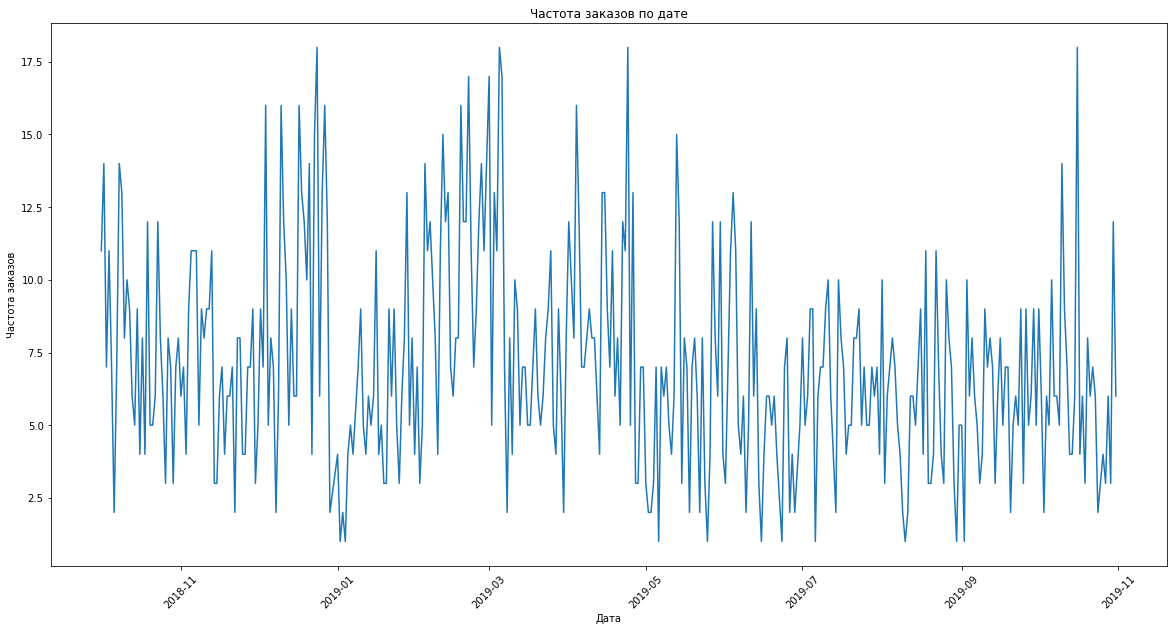

In [28]:
clean_data.groupby('dt').agg({'order_id':'nunique'}).plot(figsize=(20, 10), legend = False)
plt.title('Частота заказов по дате')
plt.ylabel("Частота заказов")
plt.xlabel("Дата")
plt.xticks(rotation=45)
plt.show()

По графику видим, что активности по частоте уникальных заказов в декабре и марте, а худшие показатели летом. В Новогодние праздники так же совсем мало заказов.

### Проверим выбросы в данных.

График выбросов по:  quantity


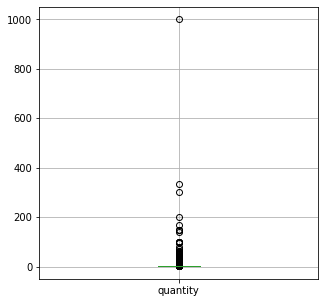

График выбросов по:  price


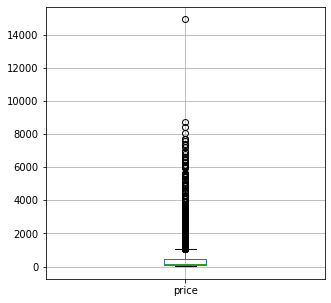

In [29]:
for i in ['quantity', 'price']:
    print('График выбросов по: ', i)
    clean_data[[i]].boxplot(figsize=(5, 5)),
    plt.show() 

Уберем выброс по столбцу *price*, так как этот заказ тестовый.

In [30]:
clean_data = clean_data.query('price<14000').reset_index()

In [31]:
clean_data['price'].describe()

count    4806.000000
mean      511.869330
std       923.474006
min         9.000000
25%        90.000000
50%       150.000000
75%       488.000000
max      8737.000000
Name: price, dtype: float64

### Создадим столбец с ценовой категорией товара.

Создадим функцию, которая возвращает ценовую группу по значению цены товара price, используя правила:

    - 'дешевые', если price <= 500;
    
    - 'недорогие', если price от 500 до 2000;
    
    - 'средние' — от 2000 до 5000;
    
    - 'дорогие' - стоимость более 5000. 
  
  
Проанализировав боксплот и характеристики по столбцу *price* решила выбрать именно такие значения ( 500, 2000, 5000 руб.).

In [32]:
def price_category(price):
    """
    Возвращает ценовую группу по значению цены товара price, используя правила:
    - 'дешевые', если price <= 500;
    - 'недорогие', если price от 500 до 2000;
    - 'средние' — от 2000 до 5000;
    - 'дорогие' - стоимость более 5000. 
    """
    
    if price <= 500:
        return 'дешевые'
    if price <= 2000 and price>500:
        return 'недорогие'
    if price > 5000:
        return 'дорогие'
    return 'средние' 

In [33]:
clean_data['price_category'] = clean_data['price'].apply(price_category)

In [34]:
clean_data.tail(20)

,index,customer_id,order_id,product,quantity,price,date,dt,price_category
4786,4787,cdaf413b-09ae-48c0-8cfa-5cd6b71948c6,73130,Пеларгония розебудная Apple Blossom укорененный черенок,1,149.0,2019-10-29 15:00:00,2019-10-29,дешевые
4787,4788,cdaf413b-09ae-48c0-8cfa-5cd6b71948c6,73131,Пеларгония розебудная Red Pandora укорененный черенок,1,149.0,2019-10-29 15:00:00,2019-10-29,дешевые
4788,4789,ffaeab76-3a8d-49ee-860f-17273b2fc8a2,73136,"Таз пластмассовый со стиральной доской (Иж), 1404021",1,397.0,2019-10-30 07:00:00,2019-10-30,дешевые
4789,4790,344aa778-e436-419e-a9c6-9b8f37b7c1df,73137,Сумка-тележка 2-х колесная Gimi Argo синяя,1,1087.0,2019-10-30 09:00:00,2019-10-30,недорогие
4790,4791,6406e169-0238-44c4-8ab5-e20190778679,73138,Пеларгония розебудная Queen Ingrid укорененный черенок,3,149.0,2019-10-30 09:00:00,2019-10-30,дешевые
4791,4792,55f5aaea-0a3f-46c0-8677-e0d5be2d19ee,73140,"Сушилка для белья потолочная Лиана 1,3 м 1703002",1,509.0,2019-10-30 10:00:00,2019-10-30,недорогие
4792,4793,55f5aaea-0a3f-46c0-8677-e0d5be2d19ee,73141,Сушилка для белья потолочно-настенная Gimi Lift 140,1,1349.0,2019-10-30 10:00:00,2019-10-30,недорогие
4793,4794,78b878f7-7f2d-4069-bcf0-0e3531583696,73142,Искусственный цветок Ромашка пластик 45 см,4,22.0,2019-10-30 12:00:00,2019-10-30,дешевые
4794,4795,8a83e422-37fc-4333-b26a-e3a0e89d197b,73143,Полки QWERTY Италия белый/серый 40х14х10 см 35х10х10 см 30х7х10 см 72006,1,1949.0,2019-10-30 13:00:00,2019-10-30,недорогие
4795,4796,12157e93-5760-473d-bb0d-ac8b3be1c5ca,73144,Эвкалипт Гунни d-14 см h-70 см,1,524.0,2019-10-30 15:00:00,2019-10-30,недорогие


In [35]:
fig = go.Figure(go.Pie(
labels = ['дешевые', 'недорогие', 'средние', 'дорогие'],
values = clean_data['quantity'].value_counts().to_list(),
    title='Количество товаров по ценовым категориям'))
fig.update_traces(textposition='inside', textinfo='percent+value+label')
fig.show()

По круговой диаграмме количества товаров, распределенных по ценовым категориям видим, что преобладают "дешевые" товары, товары средней и дорогой ценовой категории - всего лишь около 5,5%.

### Создадим столбец с общей выручкой по каждому заказу *revenue*.

In [36]:
clean_data['revenue'] = clean_data['price'] * clean_data['quantity']

In [37]:
clean_data.head()

,index,customer_id,order_id,product,quantity,price,date,dt,price_category,revenue
0,0,ee47d746-6d2f-4d3c-9622-c31412542920,68477,"Комнатное растение в горшке Алое Вера, d12, h30",1,142.0,2018-10-01,2018-10-01,дешевые,142.0
1,1,ee47d746-6d2f-4d3c-9622-c31412542920,68477,"Комнатное растение в горшке Кофе Арабика, d12, h25",1,194.0,2018-10-01,2018-10-01,дешевые,194.0
2,2,ee47d746-6d2f-4d3c-9622-c31412542920,68477,Радермахера d-12 см h-20 см,1,112.0,2018-10-01,2018-10-01,дешевые,112.0
3,3,ee47d746-6d2f-4d3c-9622-c31412542920,68477,Хризолидокарпус Лутесценс d-9 см,1,179.0,2018-10-01,2018-10-01,дешевые,179.0
4,4,ee47d746-6d2f-4d3c-9622-c31412542920,68477,Циперус Зумула d-12 см h-25 см,1,112.0,2018-10-01,2018-10-01,дешевые,112.0


### Посмотрим количество уникальных товаров и наиболее часто встречающиеся позиции.

In [38]:
clean_data['product'].value_counts()

Пеларгония розебудная Red Pandora укорененный черенок                                                             64
Пеларгония розебудная Prins Nikolai укорененный черенок                                                           53
Пеларгония зональная диам. 12 см сиреневый полумахровый                                                           52
Сумка-тележка 2-х колесная Gimi Argo синяя                                                                        47
Пеларгония розебудная Mary укорененный черенок                                                                    39
                                                                                                                  ..
томата (помидор) Абруццо № 3 сорт индетерминантный среднеспелый красный                                            1
Бальзам для мытья посуды Mama Ultimate EcoSoda 1000 мл Россия 044684                                               1
Сковорода алюминиевая с антипригарным покрытием Scovo Expert СЭ-

In [39]:
print(clean_data['product'].nunique())

2330


2330 уникальных товара и наиболее часто встречаются растения - "Пеларгония розебудная" в нескольких вариациях и "Сумка-тележка 2-х колесная Gimi Argo синяя".


### Разбивка товаров по категориям.

Приведем столбец *product* к подобающему виду, исключим знаки припинания, создадим столбец *product_clean* 

In [40]:
# Удаление знаков пунктуации из текста
def remove_punct(text):
    table = {33: ' ', 34: ' ', 35: ' ', 36: ' ', 37: ' ', 38: ' ', 39: ' ', 40: ' ', 41: ' ', 42: ' ', 43: ' ', 44: ' ', 45: ' ', 46: ' ', 47: ' ', 58: ' ', 59: ' ', 60: ' ', 61: ' ', 62: ' ', 63: ' ', 64: ' ', 91: ' ', 92: ' ', 93: ' ', 94: ' ', 95: ' ', 96: ' ', 123: ' ', 124: ' ', 125: ' ', 126: ' '}
    return text.translate(table)

clean_data['product_clean'] = clean_data['product'].map(lambda x: x.lower())
clean_data['product_clean'] = clean_data['product_clean'].map(lambda x: remove_punct(x))
clean_data['product_clean'] = clean_data['product_clean'].map(lambda x: x.split(' '))
clean_data['product_clean'] = clean_data['product_clean'].map(lambda x: [token for token in x if token not in russian_stopwords\
                                                                  and token != " " \
                                                                  and token.strip() not in punctuation])
clean_data['product_clean'] = clean_data['product_clean'].map(lambda x: ' '.join(x))
#clean_data['product_clean'] =  clean_data['product_clean'].apply(lambda x: re.sub(r'[^А-Яа-я| d -]', '', str(x)))


In [41]:
clean_data.head()

,index,customer_id,order_id,product,quantity,price,date,dt,price_category,revenue,product_clean
0,0,ee47d746-6d2f-4d3c-9622-c31412542920,68477,"Комнатное растение в горшке Алое Вера, d12, h30",1,142.0,2018-10-01,2018-10-01,дешевые,142.0,комнатное растение горшке алое вера d12 h30
1,1,ee47d746-6d2f-4d3c-9622-c31412542920,68477,"Комнатное растение в горшке Кофе Арабика, d12, h25",1,194.0,2018-10-01,2018-10-01,дешевые,194.0,комнатное растение горшке кофе арабика d12 h25
2,2,ee47d746-6d2f-4d3c-9622-c31412542920,68477,Радермахера d-12 см h-20 см,1,112.0,2018-10-01,2018-10-01,дешевые,112.0,радермахера d 12 см h 20 см
3,3,ee47d746-6d2f-4d3c-9622-c31412542920,68477,Хризолидокарпус Лутесценс d-9 см,1,179.0,2018-10-01,2018-10-01,дешевые,179.0,хризолидокарпус лутесценс d 9 см
4,4,ee47d746-6d2f-4d3c-9622-c31412542920,68477,Циперус Зумула d-12 см h-25 см,1,112.0,2018-10-01,2018-10-01,дешевые,112.0,циперус зумула d 12 см h 25 см


На выходе получили "чистые" названия продуктов.

Посмотрим какие слова встречаются в наименованиях товара чаще всего.

In [42]:
# Получение списка всех слов в корпусе
def get_corpus(clean_data):
    corpus = []
    for phrase in clean_data:
        for word in phrase.split():
            corpus.append(word)
    return corpus

In [43]:
# Получение текстовой строки из списка слов
def str_corpus(corpus):
    str_corpus = ''
    for i in corpus:
        str_corpus += ' ' + i
    str_corpus = str_corpus.strip()
    return str_corpus

In [44]:
# Получение облака слов
def get_wordCloud(corpus):
    wordCloud = WordCloud(background_color='white',
                              stopwords=STOPWORDS,
                              width=3000,
                              height=2500,
                              max_words=200,
                              random_state=42
                         ).generate(str_corpus(corpus))
    return wordCloud

In [45]:
corpus = get_corpus(clean_data['product_clean'].values)
procWordCloud = get_wordCloud(corpus)

/tmp/ipykernel_154/3346902696.py:6: MatplotlibDeprecationWarning:

Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.



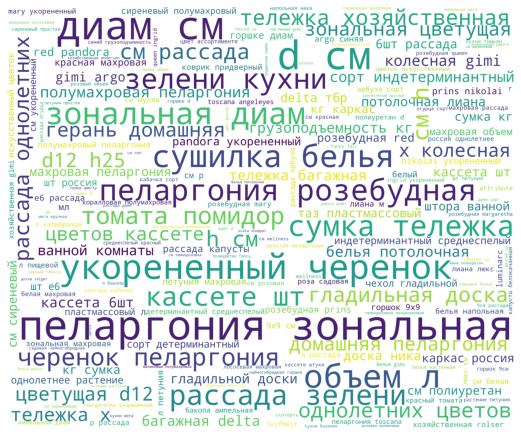

In [46]:
fig = plt.figure(figsize=(20, 8))
plt.subplot(1, 2, 1)
plt.imshow(procWordCloud)
plt.axis('off')

plt.subplot(1, 2, 1);

In [47]:
num_words = len(set(corpus))
num_words

4990

Получили визуализацию наиболее часто встречающихся слов, это - пеларгония зональная, диам, объем, укорененный черенок и т.д.

Всего уникальных слов 4990, создадим список *words_s*, который будет содержать количество упоминаний каждого слова в отдельности.

In [48]:
wc = pd.DataFrame(clean_data['product_clean'].value_counts())
wc

,product_clean
пеларгония розебудная red pandora укорененный черенок,64
пеларгония розебудная prins nikolai укорененный черенок,53
пеларгония зональная диам 12 см сиреневый полумахровый,52
сумка тележка 2 х колесная gimi argo синяя,47
пеларгония розебудная mary укорененный черенок,39
...,...
тарелка обеденная лимон фиц 25см g9547 luminarc франция,1
корзина глаженного белья natural style пластиковая темно серая 45 л 38х59 2х27 см curver d 00708 308,1
левкой рассада однолетних цветов горшке диам 12 см,1
салатник амори браун 16 5 см j2113 luminarc,1


In [49]:
words = []
for i in range(0,len(clean_data)):
    x = clean_data['product_clean'][i].split(" ")
    for j in x:
        words.append(j)

In [50]:
words

['комнатное',
 'растение',
 'горшке',
 'алое',
 'вера',
 'd12',
 'h30',
 'комнатное',
 'растение',
 'горшке',
 'кофе',
 'арабика',
 'd12',
 'h25',
 'радермахера',
 'd',
 '12',
 'см',
 'h',
 '20',
 'см',
 'хризолидокарпус',
 'лутесценс',
 'd',
 '9',
 'см',
 'циперус',
 'зумула',
 'd',
 '12',
 'см',
 'h',
 '25',
 'см',
 'шеффлера',
 'лузеана',
 'd',
 '9',
 'см',
 'юкка',
 'нитчатая',
 'd',
 '12',
 'см',
 'h',
 '25',
 '35',
 'см',
 'настенная',
 'сушилка',
 'белья',
 'gimi',
 'brio',
 'super',
 '100',
 'таз',
 'пластмассовый',
 '21',
 '0',
 'л',
 'круглый',
 'водолей',
 'с614',
 '1404056',
 'чехол',
 'гладильной',
 'доски',
 'colombo',
 'persia',
 'beige',
 '130х50',
 'см',
 'хлопка',
 '5379',
 'вешалка',
 'брюк',
 'металлическая',
 'резиновым',
 'покрытием',
 '26',
 'см',
 'цвет',
 'синяя',
 'attribute',
 'ahs331',
 'сушилка',
 'белья',
 'потолочная',
 'zalger',
 'lift',
 'basic',
 '1520',
 '200',
 'см',
 '10',
 'м',
 'чехол',
 'eurogold',
 'clean',
 'basic',
 'хлопок',
 'досок',
 '120х3

In [51]:
words_s = pd.Series(words)

In [52]:
words_s.value_counts().head(50)

см               2116
пеларгония        820
рассада           606
л                 491
зональная         487
d                 461
диам              452
12                446
5                 386
шт                374
сорт              369
0                 367
черенок           330
укорененный       330
тележка           329
9                 328
махровая          322
сумка             311
белья             304
объем             296
сушилка           272
2                 264
6                 245
розебудная        243
кассете           240
gimi              232
кухни             225
зелени            220
10                209
4                 188
7                 184
белая             174
горшке            171
петуния           170
30                169
муляж             167
россия            167
кассета           166
томата            162
помидор           162
кг                159
ника              154
1                 152
м                 151
h                 148
красная   

Аббревиатура см встречается больше двух тысяч раз это почти половина сторк в датасете, слово пеларгония - 820 раз.

По данным можем определили три категории - *растения*, *для дома*, *сумки* . Категория *сумки* будет включать сумки-тележки, тележки хозяйственные и т.д. Создадим списки основных слов принадлежности к группам и применим распределение по категориям. Создадим столбец *product_category*.

In [53]:
words = clean_data['product_clean'][0].split(" ")

In [54]:
for i in words:
    print(i)

комнатное
растение
горшке
алое
вера
d12
h30


In [55]:
garden_words = ['пеларгония', 'зональная', 'растение', 'рассада', 'розебудная', 'сорт', 'черенок', 'укорененный', \
                'петуния', 'помидор', 'петуния','d']
house = ['муляж', 'сковорода', 'гладильная', 'сушилка', 'чехол', 'доска', 'скатерть']

bags = ['тележка', 'сумка', 'корзина', 'тележки']

In [56]:
def product_category(df):
    """
    Возвращает категорию по значению наименования товара product, используя правила:
    - 'для дома', если product так или иначе относится к данной категории;
    - 'для сада', если product так или иначе относится к категории "для дома";
    - 'сумки',  если product так или иначе относится к данной категории. 
    """
    for i in df:
        item = []
        pop = []
        bask = []
        for j in df.split(" "):
            if j in garden_words:
                item.append('растения')
            if j in house:
                pop.append('q')
            if j in bags:
                bask.append('сумки')
        if pop:
            return 'для дома'
        elif item:
             return 'растения'
        elif bask:
            return 'сумки'
        else:
            return 'для дома'


In [57]:
clean_data['product_category'] = clean_data['product_clean'].apply(product_category)

In [58]:
clean_data.tail(50)

,index,customer_id,order_id,product,quantity,price,date,dt,price_category,revenue,product_clean,product_category
4756,4757,ad9c1a91-504d-416a-924c-430d5db3805a,14946,Пеларгония зональная диам. 12 см белая махровая,2,188.0,2019-10-22 13:00:00,2019-10-22,дешевые,376.0,пеларгония зональная диам 12 см белая махровая,растения
4757,4758,ffe82299-3f5b-4214-87fe-3d36ecccfac3,73060,"Сушилка для белья потолочная Лиана 1,8 м 1703007",1,577.0,2019-10-22 13:00:00,2019-10-22,недорогие,577.0,сушилка белья потолочная лиана 1 8 м 1703007,для дома
4758,4759,511115b7-e981-4069-9e0e-88a3551341a6,73063,Муляж Яблоко зеленый 9 см полиуретан,50,51.0,2019-10-22 16:00:00,2019-10-22,дешевые,2550.0,муляж яблоко зеленый 9 см полиуретан,для дома
4759,4760,9683e7c6-70a6-471c-824a-4847fd2f9874,73066,Сушилка для белья потолочная Zalger Lift Comfort 520 180 см 9 м,1,375.0,2019-10-22 19:00:00,2019-10-22,дешевые,375.0,сушилка белья потолочная zalger lift comfort 520 180 см 9 м,для дома
4760,4761,d7fd4d71-beca-46b9-bc27-3d79b81107c3,73068,Гладильная доска Hausmann Classic MONO 120x38 cм HM-2122,1,2399.0,2019-10-22 21:00:00,2019-10-22,средние,2399.0,гладильная доска hausmann classic mono 120x38 cм hm 2122,для дома
4761,4762,0efde029-f588-4d48-9a62-a90597443d0f,73069,Сушилка для белья потолочно-настенная Gimi Lift 200,2,1649.0,2019-10-23 09:00:00,2019-10-23,недорогие,3298.0,сушилка белья потолочно настенная gimi lift 200,для дома
4762,4763,73d1cd35-5e5f-4629-8cf2-3fda829d4e58,73071,"Сушилка для белья потолочная Лиана 2,2 м 1703010",1,697.0,2019-10-23 10:00:00,2019-10-23,недорогие,697.0,сушилка белья потолочная лиана 2 2 м 1703010,для дома
4763,4764,99534a35-886b-41fe-9d29-b5e5c56cb051,73072,Эвкалипт Сильвердроп d-7 см h-30 см,1,74.0,2019-10-23 11:00:00,2019-10-23,дешевые,74.0,эвкалипт сильвердроп d 7 см h 30 см,растения
4764,4765,2fac41bf-e800-4bc3-a4b3-0df800f33e99,73073,"Ведро резинопластиковое строительное 12,0 л (МП), 1402018",50,64.0,2019-10-23 11:00:00,2019-10-23,дешевые,3200.0,ведро резинопластиковое строительное 12 0 л мп 1402018,для дома
4765,4766,88d69ff9-be24-4913-bfd5-83e40e3f303f,73074,Душица обыкновенная d-9 см,1,74.0,2019-10-23 12:00:00,2019-10-23,дешевые,74.0,душица обыкновенная d 9 см,растения


In [59]:
clean_data.groupby('product_category')[['order_id']].nunique().sort_values(by='order_id')

,order_id
product_category,
сумки,370
растения,728
для дома,1755


При подсчете количества уникальных товаров принадлежных к той или иной категории, видим, что товары для дома явно преобладают, растения на втором месте. Сумки в наименьшем количестве, вероятно из-за неразнообразия товара.

### Визуализируем среднюю стоимость и количество товаров по категориям.

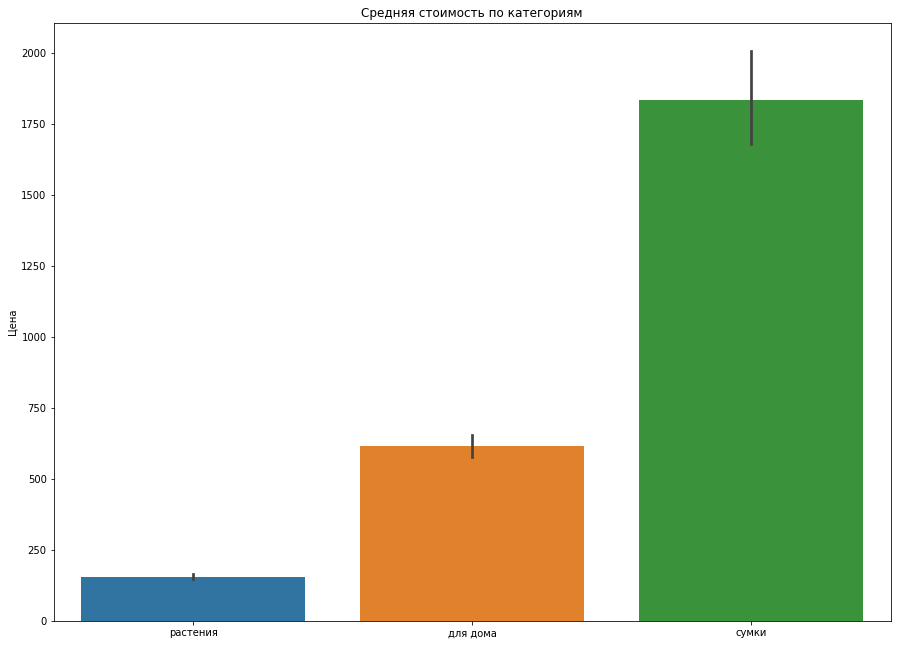

In [60]:
plt.figure(figsize=(15, 11))
sns.barplot(data=clean_data, y='price', x='product_category')
plt.xlabel('')
plt.ylabel('Цена')
plt.title('Средняя стоимость по категориям')
plt.show()

In [61]:
category = clean_data.pivot_table(index='product_category', columns='price_category', \
                                  values='order_id', aggfunc='nunique').sort_values(by='product_category',
                                                                                   ascending=False).reset_index()

In [62]:
category

price_category,product_category,дешевые,дорогие,недорогие,средние
0,сумки,37.0,29.0,231.0,74.0
1,растения,677.0,NaN,51.0,3.0
2,для дома,1014.0,18.0,620.0,132.0


In [63]:
fig = px.bar(category, x='product_category', y=['дешевые','средние','недорогие','дорогие'],
       title="Количество товаров каждой категории по ценовой категории", 
            height=500)
fig.update_layout (xaxis_title = 'Категория товара', yaxis_title = 'Количество товаров', legend_title='Ценовая категория')
update_xtitle = ('Категория товара')
update_xtitle = ('Количество товаров')
fig.show()

По графикам видим, что сумки в среднем всегда дороже, нежели товары для дома или растения. В товарах для дома преобладают недорогие и дешевые, в то время, как практически все растения отностят к дешевым товарам.

### Изучим общие показатели магазина (общая выручка, средняя выручка, средний чек и т.д.).

In [64]:
print('Общая выручка магазина:', clean_data['revenue'].sum())

Общая выручка магазина: 4079698.0


In [65]:
print('Средняя выручка магазина в месяц:', round(clean_data['revenue'].sum()/13))

Средняя выручка магазина в месяц: 313823


In [66]:
print('Средняя выручка с покупателя:', round(clean_data['revenue'].sum()/clean_data['customer_id'].nunique()))

Средняя выручка с покупателя: 1705


In [67]:
print('Средний чек:', round(clean_data['revenue'].sum()/clean_data['order_id'].nunique()))

Средний чек: 1481


Общая выручка магазина за данный период - 4079698 рублей, средняя выручка с покупателя - 1705 рублей, средний чек - 1481 рублей, средняя выручка в месяц - 313823 р.

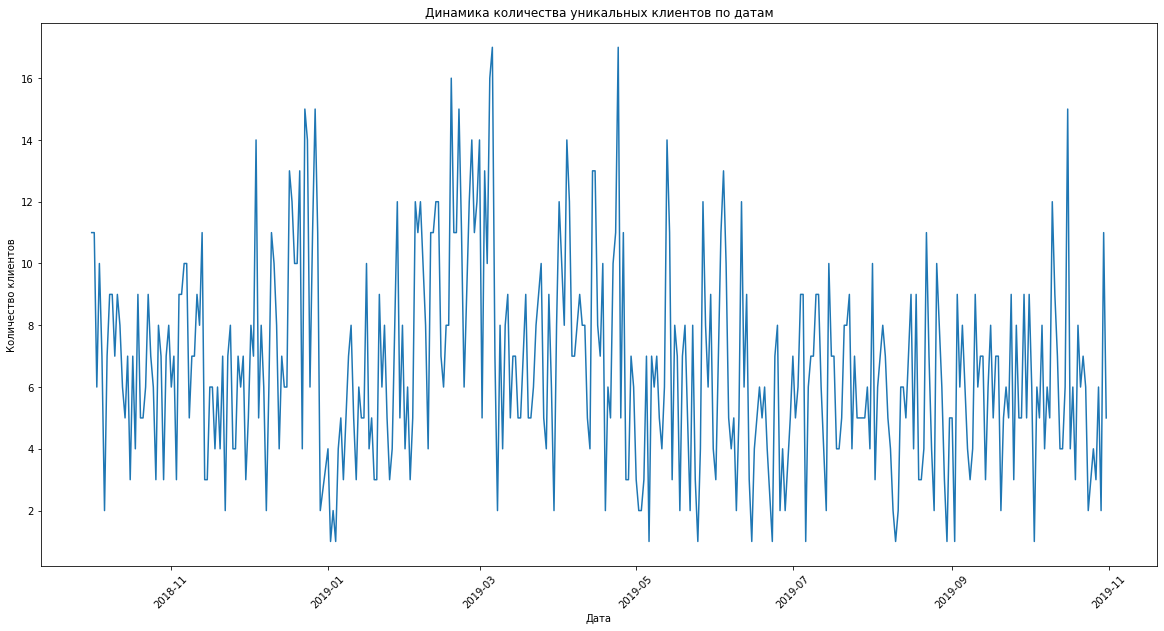

In [68]:
clean_data.groupby('dt').agg({'customer_id':'nunique'}).plot(figsize=(20, 10), legend = False)
plt.title('Динамика количества уникальных клиентов по датам')
plt.ylabel("Количество клиентов")
plt.xlabel("Дата")
plt.xticks(rotation=45)
plt.show()

Визуализировали динамику количества уникальных клиентов по датам. Видим, что летом самые низкие показатели, всплески активности в декабре, феврале и апреле.

Определим границу выбросов по количеству товаров в корзине, чтобы определить среднее количество заказов.

In [69]:
#Добавлено ревьюером

np.quantile(clean_data['quantity'], .95)

7.0

In [70]:
round(np.mean(clean_data['quantity']) + np.std(clean_data['quantity']) * 3)

56

In [71]:
print('Среднее количество товаров в корзине:', round(clean_data.query('quantity <= 56')['quantity'].mean()))

Среднее количество товаров в корзине: 2


Среднее количество товаров в корзине: 2.

### Проанализируем сезонность, распределим даты по временам года.

Создадим столбец *season*, используя правила:

    - '1 зима', если месяц покупки соответствует данному времени года;
    
    - '2 весна', если месяц покупки соответствует данному времени года;
    
    - '3 лето' — если месяц покупки соответствует данному времени года;
    
    - '4 осень' - если месяц покупки соответствует данному времени года. 

In [72]:
clean_data['date'][0].month

10

In [73]:
def season(date):
    """
    Возвращает время года из столбца date, используя правила:
    - '1 зима', если месяц покупки соответствует данному времени года;
    - '2 весна', если месяц покупки соответствует данному времени года;
    - '3 лето' — если месяц покупки соответствует данному времени года;
    - '4 осень' - если месяц покупки соответствует данному времени года. 
    """
    
    if date.month in (12,1,2)  :
        return '1 зима'
    if date.month in (3,4,5):
        return '2 весна'
    if date.month in (6,7,8):
        return '3 лето'
    return '4 осень' 

In [74]:
clean_data['season'] = clean_data['date'].apply(season)

In [75]:
clean_data.head()

,index,customer_id,order_id,product,quantity,price,date,dt,price_category,revenue,product_clean,product_category,season
0,0,ee47d746-6d2f-4d3c-9622-c31412542920,68477,"Комнатное растение в горшке Алое Вера, d12, h30",1,142.0,2018-10-01,2018-10-01,дешевые,142.0,комнатное растение горшке алое вера d12 h30,растения,4 осень
1,1,ee47d746-6d2f-4d3c-9622-c31412542920,68477,"Комнатное растение в горшке Кофе Арабика, d12, h25",1,194.0,2018-10-01,2018-10-01,дешевые,194.0,комнатное растение горшке кофе арабика d12 h25,растения,4 осень
2,2,ee47d746-6d2f-4d3c-9622-c31412542920,68477,Радермахера d-12 см h-20 см,1,112.0,2018-10-01,2018-10-01,дешевые,112.0,радермахера d 12 см h 20 см,растения,4 осень
3,3,ee47d746-6d2f-4d3c-9622-c31412542920,68477,Хризолидокарпус Лутесценс d-9 см,1,179.0,2018-10-01,2018-10-01,дешевые,179.0,хризолидокарпус лутесценс d 9 см,растения,4 осень
4,4,ee47d746-6d2f-4d3c-9622-c31412542920,68477,Циперус Зумула d-12 см h-25 см,1,112.0,2018-10-01,2018-10-01,дешевые,112.0,циперус зумула d 12 см h 25 см,растения,4 осень


Построим диаграммы динамики количества уникальных заказов и пользователей по временам года, но так как в данных есть октябрь 2018 и октябрь 2019, результат может исказиться. Предварительно отфильтруем, оставим даты до  2019-10-01.

In [76]:
#clean_data['month'] = clean_data['date'].pd.month

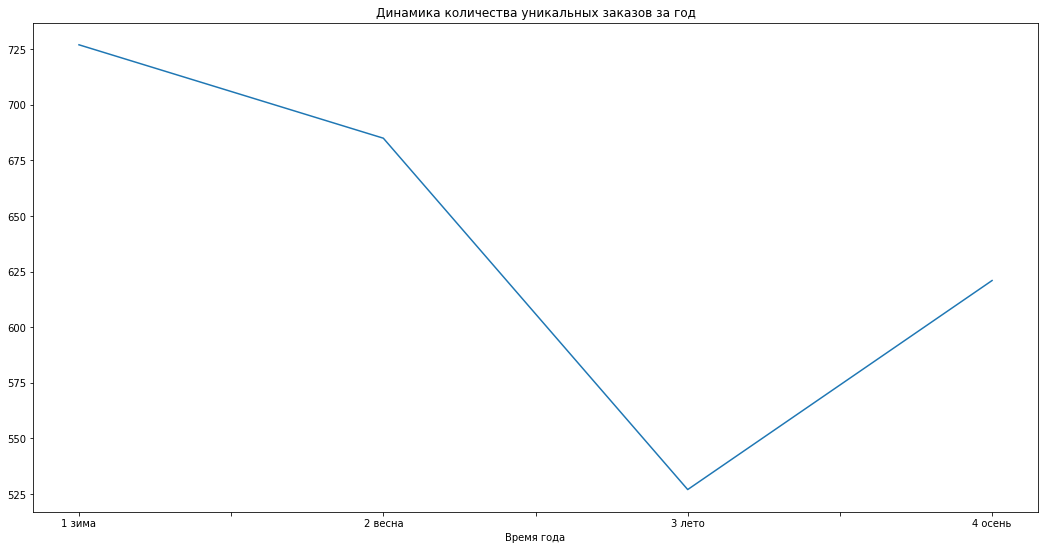

In [77]:
clean_data.query('date< "2019-10-01"').groupby('season').agg({'order_id':'nunique'}).sort_values(by=['season']).plot(figsize=(18, 9), legend=False)
plt.title('Динамика количества уникальных заказов за год')
plt.xlabel('Время года')
plt.show()

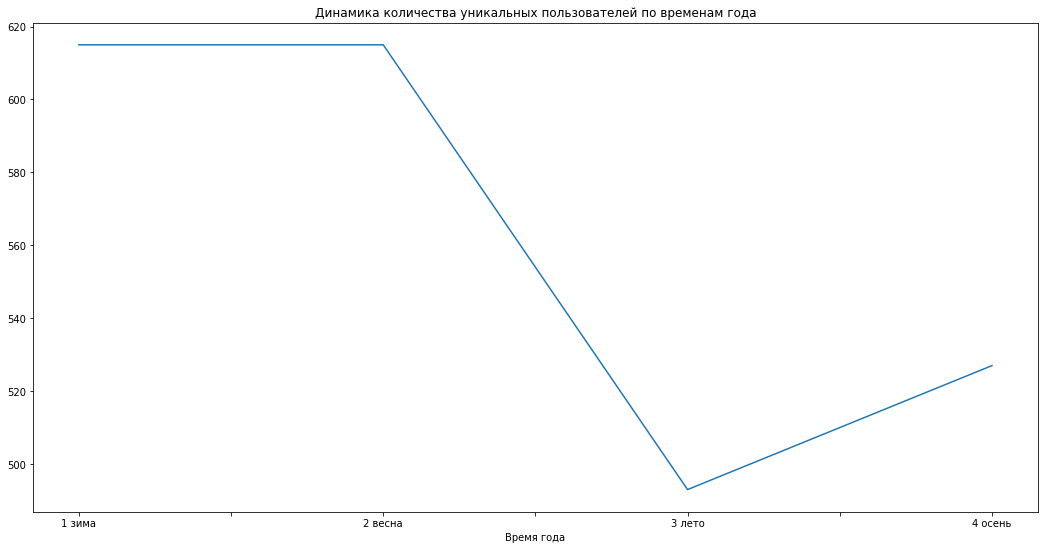

In [78]:
clean_data.query('date< "2019-10-01"').groupby('season').agg({'customer_id':'nunique'}).sort_values(by=['season']).plot(figsize=(18, 9), legend=False)
plt.title('Динамика количества уникальных пользователей по временам года')
plt.xlabel('Время года')
plt.show()

Исходя из динамики за год можно сказать, что и заказы и пользователи в упадке летом, лучшие показатели зимой и весной.


Рассмотрим динамику количества уникальных заказов по месяцам.

In [79]:
clean_data['month']=clean_data['date'].dt.month

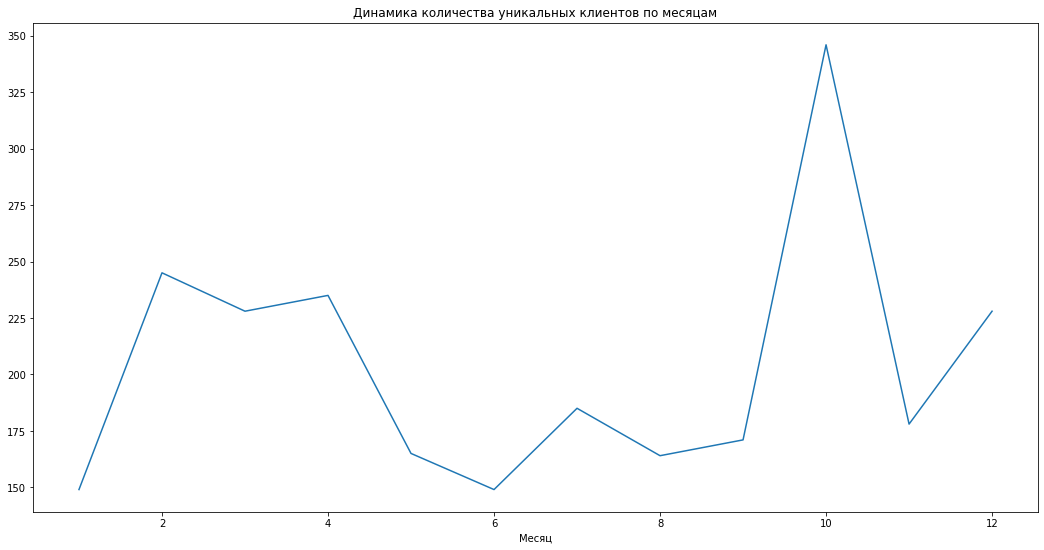

In [80]:
clean_data.groupby('month').agg({'customer_id':'nunique'}).sort_values(by=['month']).plot(figsize=(18, 9), legend=False)
plt.title('Динамика количества уникальных клиентов по месяцам')
plt.xlabel('Месяц')
plt.show()

От даты к дате число уникальных заказов меняется, так же как и в случае с уникальными пользователями. Октябрь, февраль и апрель пиковые точки в количестве уникальных пользователей. Лето провальное.
Исходя из динамики за год можно сказать, что и заказы и пользователи в упадке летом, лучшие показатели зимой и весной.
По числу покупателей ситуация такая же, наибольшее количество зимой и весной, летом наименьшее.



### Выводы по исследовательскому анализу:
* Данные есть, как за октябрь 2018, так и за октябрь 2019. Максимальная дата: 2019-10-31, минимальная дата: 2018-10-01;
* Распределили товары по ценовым категориям - дешевые, недорогие, средние и дорогие. Преобладают "дешевые" товары, товары средней и дорогой ценовой категории - всего лишь 5,5%.
* Выявили 2330  уникальных товара и наиболее часто встречаются растения - "Пеларгония розебудная" в нескольких вариациях и "Сумка-тележка 2-х колесная Gimi Argo синяя".
* Определили три категории товаров - "растения", "для дома", "сумки". При подсчете количества уникальных товаров принадлежных к той или иной категории, увидели, что товары для дома явно преобладают.
* Сумки в среднем всегда дороже, нежели товары для дома или растения. В товарах для дома преобладают недорогие и дешевые, в то время, как практически все растения отностят к дешевым товарам.
* Общая выручка магазина за данный период - 4079698 рублей, средняя выручка с покупателя - 1705 рублей, средний чек - 1481 рублей, средняя выручка в месяц - 313823 р.
* Разбили заказы по сезонам - зима, весна, лето и осень.
* От даты к дате число уникальных заказов меняется, так же как и в случае с уникальными пользователями. Октябрь, февраль и апрель пиковые точки в количестве уникальных пользователей. Лето провальное.
* Исходя из динамики за год можно сказать, что и заказы и пользователи в упадке летом, лучшие показатели зимой и весной. По числу покупателей ситуация такая же, наибольшее количество зимой и весной, летом наименьшее.

##  Сегментация покупателей по профилю потребления.

### По столбцу с количеством товаров уберем выбивающееся значение, так как может исказить сегментацию.

<AxesSubplot:>

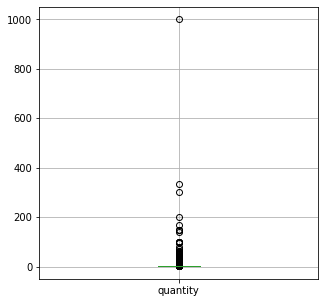

In [81]:
clean_data.boxplot('quantity', figsize=(5, 5))

In [82]:
clean_data = clean_data.query('quantity != 1000')


In [83]:
clean_data.describe()

,index,order_id,quantity,price,revenue,month
count,4805.000000,4805.000000,4805.000000,4805.000000,4805.000000,4805.000000
mean,2402.343392,47979.521124,2.602706,511.835380,708.573985,6.512383
std,1387.715956,27385.849249,10.287444,923.567116,1693.761484,3.292958
min,0.000000,12624.000000,1.000000,9.000000,9.000000,1.000000
25%,1201.000000,14770.000000,1.000000,90.000000,120.000000,4.000000
50%,2402.000000,68844.000000,1.000000,150.000000,194.000000,6.000000
75%,3603.000000,70794.000000,1.000000,488.000000,734.000000,10.000000
max,4806.000000,73164.000000,334.000000,8737.000000,49432.000000,12.000000


### Предварительно отсортируем данные для кластеров по заказам и клиентам.

In [84]:
clean_data.head(15)

,index,customer_id,order_id,product,quantity,price,date,dt,price_category,revenue,product_clean,product_category,season,month
0,0,ee47d746-6d2f-4d3c-9622-c31412542920,68477,"Комнатное растение в горшке Алое Вера, d12, h30",1,142.0,2018-10-01 00:00:00,2018-10-01,дешевые,142.0,комнатное растение горшке алое вера d12 h30,растения,4 осень,10
1,1,ee47d746-6d2f-4d3c-9622-c31412542920,68477,"Комнатное растение в горшке Кофе Арабика, d12, h25",1,194.0,2018-10-01 00:00:00,2018-10-01,дешевые,194.0,комнатное растение горшке кофе арабика d12 h25,растения,4 осень,10
2,2,ee47d746-6d2f-4d3c-9622-c31412542920,68477,Радермахера d-12 см h-20 см,1,112.0,2018-10-01 00:00:00,2018-10-01,дешевые,112.0,радермахера d 12 см h 20 см,растения,4 осень,10
3,3,ee47d746-6d2f-4d3c-9622-c31412542920,68477,Хризолидокарпус Лутесценс d-9 см,1,179.0,2018-10-01 00:00:00,2018-10-01,дешевые,179.0,хризолидокарпус лутесценс d 9 см,растения,4 осень,10
4,4,ee47d746-6d2f-4d3c-9622-c31412542920,68477,Циперус Зумула d-12 см h-25 см,1,112.0,2018-10-01 00:00:00,2018-10-01,дешевые,112.0,циперус зумула d 12 см h 25 см,растения,4 осень,10
5,5,ee47d746-6d2f-4d3c-9622-c31412542920,68477,Шеффлера Лузеана d-9 см,1,164.0,2018-10-01 00:00:00,2018-10-01,дешевые,164.0,шеффлера лузеана d 9 см,растения,4 осень,10
6,6,ee47d746-6d2f-4d3c-9622-c31412542920,68477,Юкка нитчатая d-12 см h-25-35 см,1,134.0,2018-10-01 00:00:00,2018-10-01,дешевые,134.0,юкка нитчатая d 12 см h 25 35 см,растения,4 осень,10
7,7,375e0724-f033-4c76-b579-84969cf38ee2,68479,Настенная сушилка для белья Gimi Brio Super 100,1,824.0,2018-10-01 08:00:00,2018-10-01,недорогие,824.0,настенная сушилка белья gimi brio super 100,для дома,4 осень,10
8,8,6644e5b4-9934-4863-9778-aaa125207701,68478,"Таз пластмассовый 21,0 л круглый ""Водолей"" С614, 1404056",1,269.0,2018-10-01 08:00:00,2018-10-01,дешевые,269.0,таз пластмассовый 21 0 л круглый водолей с614 1404056,для дома,4 осень,10
9,9,c971fb21-d54c-4134-938f-16b62ee86d3b,68480,Чехол для гладильной доски Colombo Persia Beige 130х50 см из хлопка 5379,1,674.0,2018-10-01 09:00:00,2018-10-01,недорогие,674.0,чехол гладильной доски colombo persia beige 130х50 см хлопка 5379,для дома,4 осень,10


In [85]:
df1 = clean_data.groupby(['customer_id']).agg({"order_id":"nunique","quantity":"sum","revenue":'sum'}) \
.rename(columns={"order_id": "order_cnt", "quantity": "quantity_sum","revenue":"revenue_total"}).reset_index()

In [86]:
df1.query('order_cnt>1').sort_values(by = 'order_cnt',ascending=False).head()

,customer_id,order_cnt,quantity_sum,revenue_total
1868,c971fb21-d54c-4134-938f-16b62ee86d3b,126,334,159508.0
725,4d93d3f6-8b24-403b-a74b-f5173e40d7db,35,309,57278.0
1072,73d1cd35-5e5f-4629-8cf2-3fda829d4e58,17,17,21361.0
1704,b7b865ab-0735-407f-8d0c-31f74d2806cc,7,68,3779.0
16,0184f535-b60a-4914-a982-231e3f615206,5,58,5891.0


In [87]:
df1['avg_check'] = df1['revenue_total']/df1['order_cnt']

In [88]:
df1['avg_quantity'] = df1['quantity_sum']/df1['order_cnt']

In [89]:
df1.query('order_cnt>1').head()

,customer_id,order_cnt,quantity_sum,revenue_total,avg_check,avg_quantity
16,0184f535-b60a-4914-a982-231e3f615206,5,58,5891.0,1178.2,11.6
31,02adb72a-3067-45e9-a3b5-f93d79d7496a,2,2,10723.0,5361.5,1.0
37,036118cf-c198-48fa-ba15-6d841482a56d,2,18,1926.0,963.0,9.0
76,07abcccf-1887-4b4e-b6bf-8054759bc419,2,4,1316.0,658.0,2.0
82,08199320-6a87-4a2c-8565-dfc0c8484184,2,2,134.0,67.0,1.0


In [90]:
df2 = clean_data.query('season == "1 зима"').groupby('customer_id').agg({"order_id":"count","revenue":'sum'}) \
.rename(columns={"order_id": "order_id_total_winter","revenue":"revenue_total_winter"}).reset_index()

In [91]:
df3 = clean_data.query('season == "2 весна"').groupby('customer_id').agg({"order_id":"count","revenue":'sum'}) \
.rename(columns={"order_id": "order_id_total_spring","revenue":"revenue_total_spring"}).reset_index()

In [92]:
df4 = clean_data.query('season == "3 лето"').groupby('customer_id').agg({"order_id":"count","revenue":'sum'}) \
.rename(columns={"order_id": "order_id_total_summer","revenue":"revenue_total_summer"}).reset_index()

In [93]:
df5 = clean_data.query('season == "4 осень"').groupby('customer_id').agg({"order_id":"count","revenue":'sum'}) \
.rename(columns={"order_id": "order_id_total_autumn","revenue":"revenue_total_autumn"}).reset_index()

In [94]:
df6 = clean_data.query('product_category == "растения"').groupby('customer_id').agg({"order_id":"count","revenue":'sum'}) \
.rename(columns={"order_id": "order_id_total_plants","revenue":"revenue_total_plants"}).reset_index()

In [95]:
df7 = clean_data.query('product_category == "для дома"').groupby('customer_id').agg({"order_id":"count","revenue":'sum'}) \
.rename(columns={"order_id": "order_id_total_house","revenue":"revenue_total_house"}).reset_index()

In [96]:
df8 = clean_data.query('product_category == "сумки"').groupby('customer_id').agg({"order_id":"count","revenue":'sum'}) \
.rename(columns={"order_id": "order_id_total_bags","revenue":"revenue_total_bags"}).reset_index() 

In [97]:
users_fich = df1.merge(df2, on = 'customer_id', how = 'left') \
                .merge(df3, on = 'customer_id', how = 'left') \
                .merge(df4, on = 'customer_id', how = 'left') \
                .merge(df5, on = 'customer_id', how = 'left') \
                .merge(df6, on = 'customer_id', how = 'left') \
                .merge(df7, on = 'customer_id', how = 'left') \
                .merge(df8, on = 'customer_id', how = 'left') 

In [98]:
users_fich = users_fich.fillna(0)

In [99]:
clust  = users_fich.drop(columns=['customer_id'])
                                  #,'order_id_total_winter','revenue_total_winter','order_id_total_spring',\
                                  #'revenue_total_spring','order_id_total_summer','revenue_total_summer','order_id_total_autumn','revenue_total_autumn'])

In [100]:
users_fich.query('order_cnt>1').sort_values(by = 'order_cnt',ascending=False).head()

,customer_id,order_cnt,quantity_sum,revenue_total,avg_check,avg_quantity,order_id_total_winter,revenue_total_winter,order_id_total_spring,revenue_total_spring,order_id_total_summer,revenue_total_summer,order_id_total_autumn,revenue_total_autumn,order_id_total_plants,revenue_total_plants,order_id_total_house,revenue_total_house,order_id_total_bags,revenue_total_bags
1868,c971fb21-d54c-4134-938f-16b62ee86d3b,126,334,159508.0,1265.936508,2.650794,77.0,97607.0,8.0,8681.0,0.0,0.0,58.0,53220.0,30.0,13674.0,91.0,95492.0,22.0,50342.0
725,4d93d3f6-8b24-403b-a74b-f5173e40d7db,35,309,57278.0,1636.514286,8.828571,0.0,0.0,0.0,0.0,0.0,0.0,45.0,57278.0,4.0,3686.0,36.0,49516.0,5.0,4076.0
1072,73d1cd35-5e5f-4629-8cf2-3fda829d4e58,17,17,21361.0,1256.529412,1.000000,0.0,0.0,0.0,0.0,0.0,0.0,17.0,21361.0,1.0,187.0,12.0,10602.0,4.0,10572.0
1704,b7b865ab-0735-407f-8d0c-31f74d2806cc,7,68,3779.0,539.857143,9.714286,5.0,660.0,13.0,3119.0,0.0,0.0,0.0,0.0,15.0,3451.0,3.0,328.0,0.0,0.0
16,0184f535-b60a-4914-a982-231e3f615206,5,58,5891.0,1178.200000,11.600000,0.0,0.0,30.0,5891.0,0.0,0.0,0.0,0.0,22.0,5171.0,8.0,720.0,0.0,0.0


Создали датафрэйм *users_fich*, который отражает общее и среднее количество заказов за весь период, общее и среднее количество наименований товара в корзине, средний чек, а так же общее количество заказов по временам года и категорям для КАЖДОГО УНИКАЛЬНОГО ПОЛЬЗОВАТЕЛЯ.

### Кластеризация.

Построим ерархическую дендрограмму кластеров товаров или по-другому дерево, которое позволяет изобразить взаимные связи между объектами из заданного множества. Для того чтобы построить дендрограму корректно необходимо избавиться от выбросов.

График выбросов по:  order_cnt


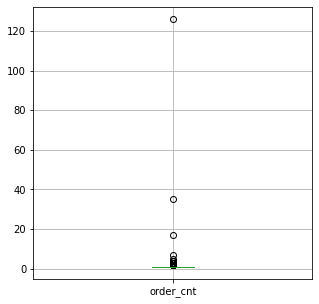

График выбросов по:  quantity_sum


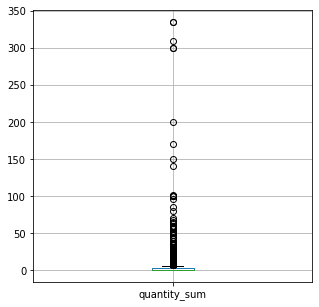

График выбросов по:  revenue_total


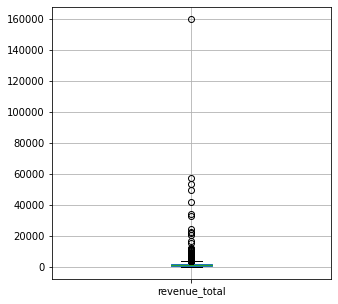

График выбросов по:  avg_check


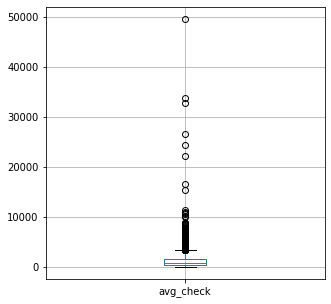

График выбросов по:  avg_quantity


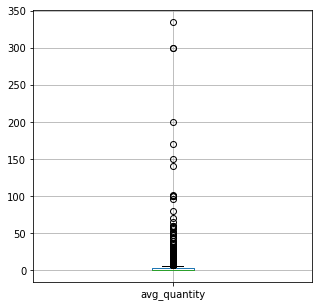

График выбросов по:  order_id_total_winter


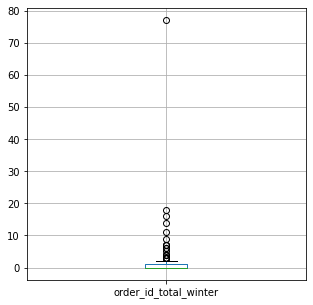

График выбросов по:  revenue_total_winter


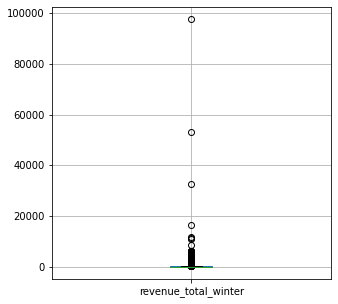

График выбросов по:  order_id_total_spring


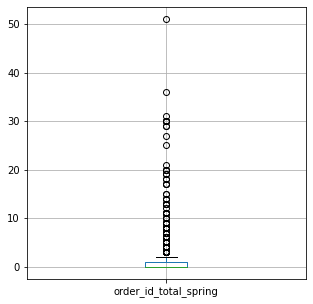

График выбросов по:  revenue_total_spring


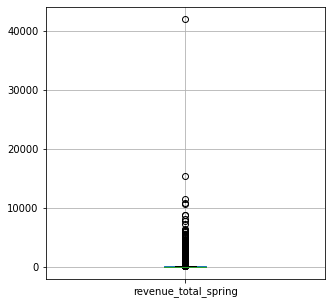

График выбросов по:  order_id_total_summer


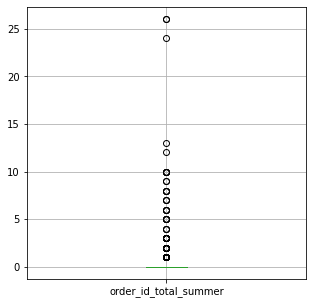

График выбросов по:  revenue_total_summer


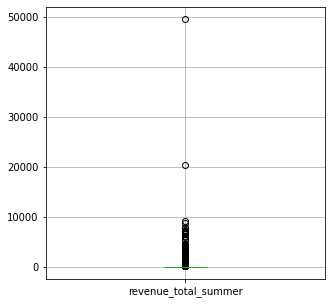

График выбросов по:  order_id_total_autumn


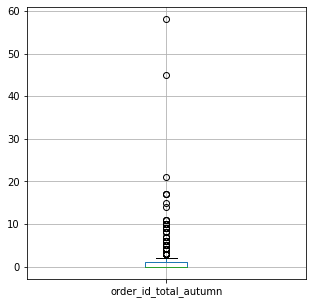

График выбросов по:  revenue_total_autumn


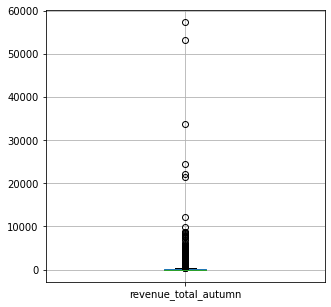

График выбросов по:  order_id_total_plants


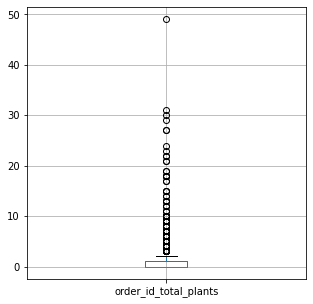

График выбросов по:  revenue_total_plants


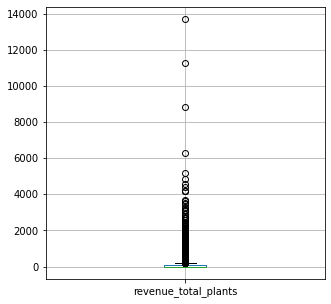

График выбросов по:  order_id_total_house


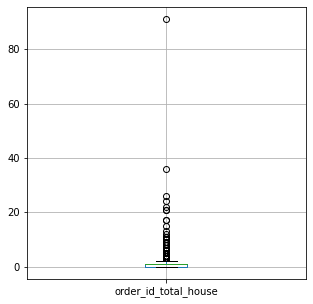

График выбросов по:  revenue_total_house


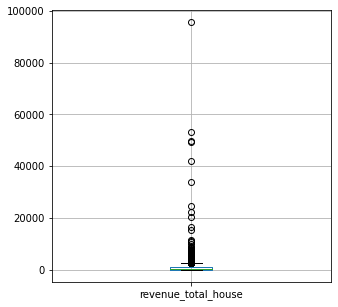

График выбросов по:  order_id_total_bags


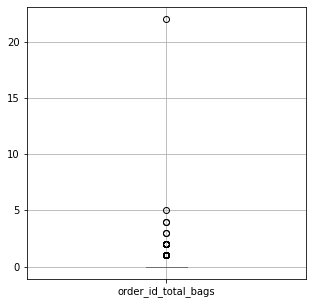

График выбросов по:  revenue_total_bags


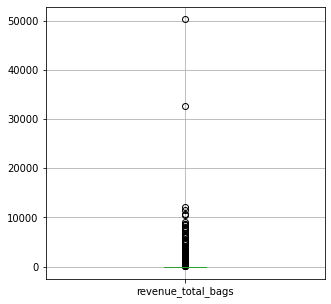

In [101]:
for i in clust.columns:
    print('График выбросов по: ', i)
    users_fich[[i]].boxplot(figsize=(5, 5)),
    plt.show() 

In [102]:
clust = np.log1p(clust)

In [103]:
sc = StandardScaler()
clsc = sc.fit_transform(clust)

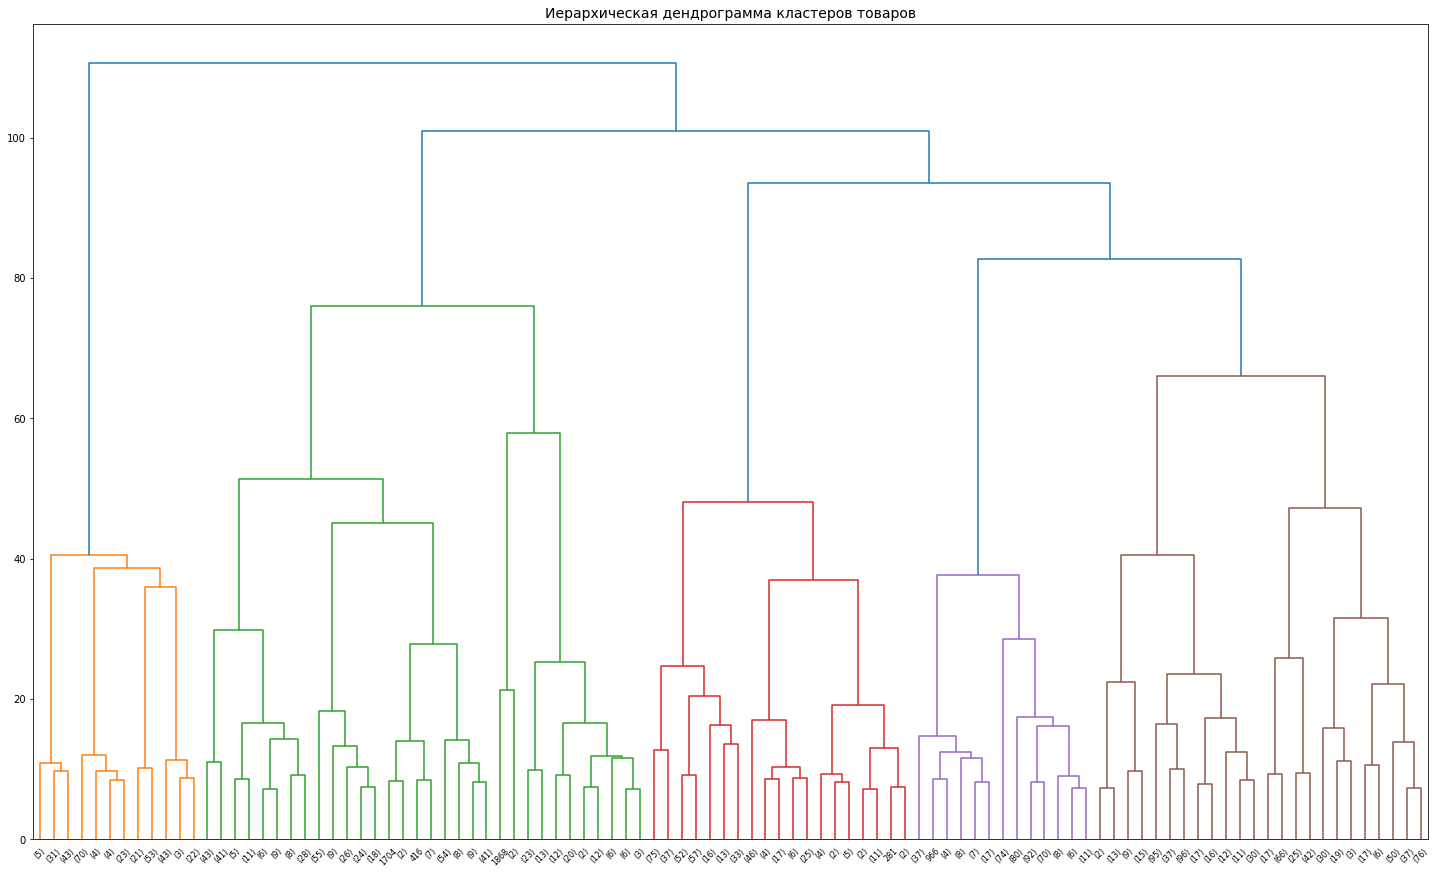

In [104]:
linked = linkage(clsc, method='ward')
plt.figure(figsize=(25, 15))
plt.title('Иерархическая дендрограмма кластеров товаров', fontsize=14)
dendrogram(linked, orientation='top', leaf_rotation=45., leaf_font_size = 8., truncate_mode='lastp', p=100, color_threshold=80)
plt.show()

По дереву четко видны 5 сегментов, но попробуем метод "локтя", чтобы определить оптимальное количество. Этот эмпирический метод вычисляет сумму квадратов расстояний между точками и вычисляет Среднее значение (Mean).

Возьмем данные из таблицы users_fich - общее количество товаров, общая выручка.

In [105]:
clusters  = clust.loc[:, ['quantity_sum','revenue_total']].values

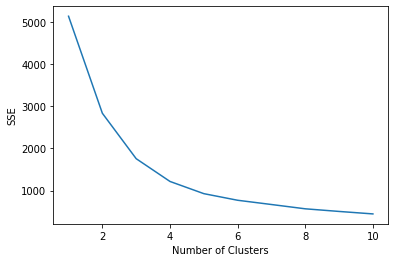

In [106]:
errors = []
for i in range(1, 11):
    kmeans = KMeans(n_clusters = i, init = 'k-means++').fit(clusters)
    errors.append(kmeans.inertia_)
plt.plot(range(1, 11), errors)
plt.xlabel("Number of Clusters")
plt.ylabel("SSE")
plt.show();

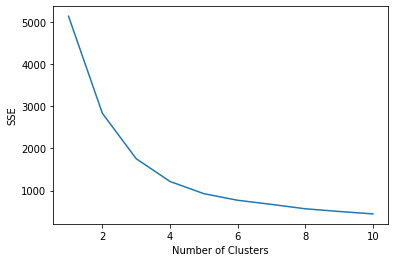

In [107]:
# Добавлено ревьюером
errors = []
for i in range(1, 11):
    kmeans = KMeans(n_clusters = i, init = 'k-means++').fit(clusters)
    errors.append(kmeans.inertia_)
plt.plot(range(1, 11), errors)
plt.xlabel("Number of Clusters")
plt.ylabel("SSE")
plt.show();

По графику видим, что ошибка перестает значительно снижаться около отметки 4, соответственно остановимся на 4х кластерах.

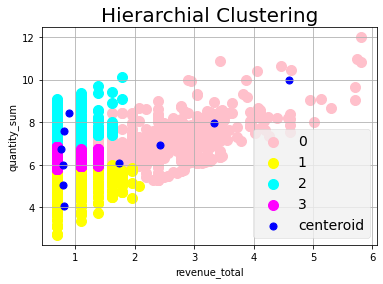

In [108]:
#выбрали Агломеративный метод - kmeans

hc = AgglomerativeClustering(n_clusters = 4, affinity = 'euclidean', linkage = 'ward')
y_hc = hc.fit_predict(clusters)
centers = kmeans.cluster_centers_

plt.scatter(clusters[y_hc == 0, 0], clusters[y_hc == 0, 1], s = 100, c = 'pink', label = '0')
plt.scatter(clusters[y_hc == 1, 0], clusters[y_hc == 1, 1], s = 100, c = 'yellow', label = '1')
plt.scatter(clusters[y_hc == 2, 0], clusters[y_hc == 2, 1], s = 100, c = 'cyan', label = '2')
plt.scatter(clusters[y_hc == 3, 0], clusters[y_hc == 3, 1], s = 100, c = 'magenta', label = '3')

plt.scatter(centers[:,0], centers[:, 1], s = 50, c = 'blue' , label = 'centeroid')

plt.style.use('fivethirtyeight')
plt.title('Hierarchial Clustering', fontsize = 20)
plt.xlabel('revenue_total')
plt.ylabel('quantity_sum')
plt.legend()
plt.grid()
plt.show()

График показывает, что в первом кластере находятся покупатели, которые делают крупные покупки и по количеству товаров в заказе и по сумме заказа. 

Второй кластер чуть меньше, здесь сосредоточены скажем рядовые покупатели, с небольшой общей суммой и общим количеством товаров.

Третий кластер еще меньше - большие суммы и малое количество товаров в заказе.

Четвертый кластер самый маленький, малое количество товаров в заказе при средней сумме заказа. 

Дальше возьмем данные о среднем чеке и о среднем количетсве товаров в заказе.

In [109]:
#kmeans.n_iter_

In [110]:
clusters  = clust.loc[:, ['avg_check', 'avg_quantity']].values

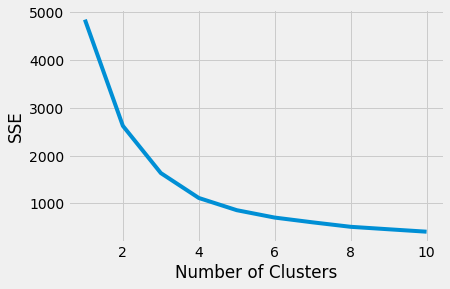

In [111]:
errors = []
for i in range(1, 11):
    kmeans = KMeans(n_clusters = i, init = 'k-means++').fit(clusters)
    errors.append(kmeans.inertia_)
plt.plot(range(1, 11), errors)
plt.ylabel("SSE")
plt.xlabel("Number of Clusters")
plt.show();

Так же остановимся на 4х кластерах.

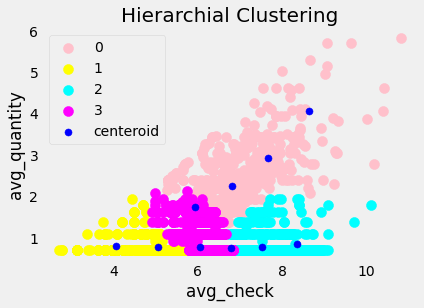

In [112]:
hc = AgglomerativeClustering(n_clusters = 4, affinity = 'euclidean', linkage = 'ward')
y_hc = hc.fit_predict(clusters)
centers = kmeans.cluster_centers_

plt.scatter(clusters[y_hc == 0, 0], clusters[y_hc == 0, 1], s = 100, c = 'pink', label = '0')
plt.scatter(clusters[y_hc == 1, 0], clusters[y_hc == 1, 1], s = 100, c = 'yellow', label = '1')
plt.scatter(clusters[y_hc == 2, 0], clusters[y_hc == 2, 1], s = 100, c = 'cyan', label = '2')
plt.scatter(clusters[y_hc == 3, 0], clusters[y_hc == 3, 1], s = 100, c = 'magenta', label = '3')
plt.scatter(centers[:,0], centers[:, 1], s = 50, c = 'blue' , label = 'centeroid')

plt.style.use('fivethirtyeight')
plt.title('Hierarchial Clustering', fontsize = 20)
plt.xlabel('avg_check')
plt.ylabel('avg_quantity')
plt.legend()
plt.grid()
plt.show()

Здесь видим, что первый кластер так же самый разбросанный, стабильно большое среднее количество товаров в заказе и высокий средний чек.

Второй кластер опять же рядовые покупатели..

Третий кластер - большой средний чек при небольшом среднем количестве товаров в заказе.

Четвертый кластер - опять же посередине.



Присвоим соответствующие значения кластеров в таблице.

In [113]:
model_km = KMeans(n_clusters = 4, random_state = 0)
labels = model_km.fit_predict(clsc)

In [114]:
users_fich['cluster'] = labels

In [115]:
cluster0 = users_fich[users_fich['cluster'] == 0]
cluster1 = users_fich[users_fich['cluster'] == 1]
cluster0 = users_fich[users_fich['cluster'] == 2]
cluster1 = users_fich[users_fich['cluster'] == 3]

In [116]:
users_fich['cluster'].value_counts()

3    689
0    612
1    602
2    489
Name: cluster, dtype: int64

In [117]:
clean_data = clean_data.merge(users_fich[['customer_id','cluster']],on='customer_id',how='left').reset_index()\
.drop(columns=['index','level_0'])

In [118]:
clean_data.head(20)

,customer_id,order_id,product,quantity,price,date,dt,price_category,revenue,product_clean,product_category,season,month,cluster
0,ee47d746-6d2f-4d3c-9622-c31412542920,68477,"Комнатное растение в горшке Алое Вера, d12, h30",1,142.0,2018-10-01 00:00:00,2018-10-01,дешевые,142.0,комнатное растение горшке алое вера d12 h30,растения,4 осень,10,3
1,ee47d746-6d2f-4d3c-9622-c31412542920,68477,"Комнатное растение в горшке Кофе Арабика, d12, h25",1,194.0,2018-10-01 00:00:00,2018-10-01,дешевые,194.0,комнатное растение горшке кофе арабика d12 h25,растения,4 осень,10,3
2,ee47d746-6d2f-4d3c-9622-c31412542920,68477,Радермахера d-12 см h-20 см,1,112.0,2018-10-01 00:00:00,2018-10-01,дешевые,112.0,радермахера d 12 см h 20 см,растения,4 осень,10,3
3,ee47d746-6d2f-4d3c-9622-c31412542920,68477,Хризолидокарпус Лутесценс d-9 см,1,179.0,2018-10-01 00:00:00,2018-10-01,дешевые,179.0,хризолидокарпус лутесценс d 9 см,растения,4 осень,10,3
4,ee47d746-6d2f-4d3c-9622-c31412542920,68477,Циперус Зумула d-12 см h-25 см,1,112.0,2018-10-01 00:00:00,2018-10-01,дешевые,112.0,циперус зумула d 12 см h 25 см,растения,4 осень,10,3
5,ee47d746-6d2f-4d3c-9622-c31412542920,68477,Шеффлера Лузеана d-9 см,1,164.0,2018-10-01 00:00:00,2018-10-01,дешевые,164.0,шеффлера лузеана d 9 см,растения,4 осень,10,3
6,ee47d746-6d2f-4d3c-9622-c31412542920,68477,Юкка нитчатая d-12 см h-25-35 см,1,134.0,2018-10-01 00:00:00,2018-10-01,дешевые,134.0,юкка нитчатая d 12 см h 25 35 см,растения,4 осень,10,3
7,375e0724-f033-4c76-b579-84969cf38ee2,68479,Настенная сушилка для белья Gimi Brio Super 100,1,824.0,2018-10-01 08:00:00,2018-10-01,недорогие,824.0,настенная сушилка белья gimi brio super 100,для дома,4 осень,10,3
8,6644e5b4-9934-4863-9778-aaa125207701,68478,"Таз пластмассовый 21,0 л круглый ""Водолей"" С614, 1404056",1,269.0,2018-10-01 08:00:00,2018-10-01,дешевые,269.0,таз пластмассовый 21 0 л круглый водолей с614 1404056,для дома,4 осень,10,3
9,c971fb21-d54c-4134-938f-16b62ee86d3b,68480,Чехол для гладильной доски Colombo Persia Beige 130х50 см из хлопка 5379,1,674.0,2018-10-01 09:00:00,2018-10-01,недорогие,674.0,чехол гладильной доски colombo persia beige 130х50 см хлопка 5379,для дома,4 осень,10,0


Из распределения кластеров видим, что 1й кластер - 612 пользователей, 2й кластер - 602 пользователя, 3й кластер - 489 пользователей, 4й кластер - 689 пользователей.


## Формулировка и проверка статистических гипотез.

Сформулируем стат гипотезы.

H_0: Статистически значимой разницы между кластерами нет; 

H_a: Статистически значимая разница между кластерами есть.



Рассмотрим разницу между показателями среднего чека.

In [119]:
stat_1 = clean_data.pivot_table(
    index=['customer_id','cluster'], values=['order_id', 'revenue'], aggfunc={'order_id':'nunique', 'revenue':'sum'}).reset_index()
stat_1['avg']= stat_1['revenue'] / stat_1['order_id']

In [120]:
check_0 = stat_1[stat_1['cluster'] == 0]['avg']
check_1 = stat_1[stat_1['cluster'] == 1]['avg']
check_2 = stat_1[stat_1['cluster'] == 2]['avg']
check_3 = stat_1[stat_1['cluster'] == 3]['avg']

In [121]:
print('Дисперсия среднего чека 0-го кластера: {}'.format(np.var(check_0, ddof=1)))
print('Дисперсия среднего чека 1-го кластера: {}'.format(np.var(check_1, ddof=1)))
print('Дисперсия среднего чека 2-го кластера: {}'.format(np.var(check_2, ddof=1)))
print('Дисперсия среднего чека 3-го кластера: {}'.format(np.var(check_3, ddof=1)))

Дисперсия среднего чека 0-го кластера: 4733808.881858066
Дисперсия среднего чека 1-го кластера: 2265573.9741767305
Дисперсия среднего чека 2-го кластера: 6780994.779645718
Дисперсия среднего чека 3-го кластера: 5021912.677059588


Дисперсии слишком разные, при проведение теста необходимо учитывать параметр equal_var. 

Так как проверка предстоит множественная (а именно 6 сравнений), нам необходимо применить поправку Бонферони значение alpha разделить на количество проверок, т.е 0,05/6.

In [122]:
alpha = 0.05/6
results = st.ttest_ind(check_0, check_1, equal_var=False)
print('p-значение: ', results.pvalue)
if results.pvalue < alpha:
    print('Отвергаем нулевую гипотезу: между сегментами 0 и 1 есть значимая разница')
else:
    print('Не получилось отвергнуть нулевую гипотезу, нет оснований считать сегменты разными')

p-значение:  0.8136780135444415
Не получилось отвергнуть нулевую гипотезу, нет оснований считать сегменты разными


In [123]:
alpha = 0.05/6
results = st.ttest_ind(check_0, check_2, equal_var=False)
print('p-значение: ', results.pvalue)
if results.pvalue < alpha:
    print('Отвергаем нулевую гипотезу: между сегментами 0 и 2 есть значимая разница')
else:
    print('Не получилось отвергнуть нулевую гипотезу, нет оснований считать сегменты разными')

p-значение:  0.9959780693523943
Не получилось отвергнуть нулевую гипотезу, нет оснований считать сегменты разными


In [124]:
alpha = 0.05/6
results = st.ttest_ind(check_0, check_3, equal_var=False)
print('p-значение: ', results.pvalue)
if results.pvalue < alpha:
    print('Отвергаем нулевую гипотезу: между сегментами 0 и 3 есть значимая разница')
else:
    print('Не получилось отвергнуть нулевую гипотезу, нет оснований считать сегменты разными')

p-значение:  0.1857878104015796
Не получилось отвергнуть нулевую гипотезу, нет оснований считать сегменты разными


In [125]:
alpha = 0.05/6
results = st.ttest_ind(check_1, check_2, equal_var=False)
print('p-значение: ', results.pvalue)
if results.pvalue < alpha:
    print('Отвергаем нулевую гипотезу: между сегментами 2 и 1 есть значимая разница')
else:
    print('Не получилось отвергнуть нулевую гипотезу, нет оснований считать сегменты разными')

p-значение:  0.8446939177593757
Не получилось отвергнуть нулевую гипотезу, нет оснований считать сегменты разными


In [126]:
alpha = 0.05/6
results = st.ttest_ind(check_3, check_2, equal_var=False)
print('p-значение: ', results.pvalue)
if results.pvalue < alpha:
    print('Отвергаем нулевую гипотезу: между сегментами 3 и 2 есть значимая разница')
else:
    print('Не получилось отвергнуть нулевую гипотезу, нет оснований считать сегменты разными')

p-значение:  0.26705823051346195
Не получилось отвергнуть нулевую гипотезу, нет оснований считать сегменты разными


In [127]:
alpha = 0.05/6
results = st.ttest_ind(check_1, check_3, equal_var=False)
print('p-значение: ', results.pvalue)
if results.pvalue < alpha:
    print('Отвергаем нулевую гипотезу: между сегментами 3 и 1 есть значимая разница')
else:
    print('Не получилось отвергнуть нулевую гипотезу, нет оснований считать сегменты разными')

p-значение:  0.07468276831219585
Не получилось отвергнуть нулевую гипотезу, нет оснований считать сегменты разными


Использовали TTtest - стат разницы между средними чеками сегментов нет.

Рассмотрим выручку кластеров.

In [128]:
rev_0 = clean_data[clean_data['cluster'] == 0].groupby('order_id').agg({'revenue':'sum'})['revenue']
rev_1 = clean_data[clean_data['cluster'] == 1].groupby('order_id').agg({'revenue':'sum'})['revenue']
rev_2 = clean_data[clean_data['cluster'] == 2].groupby('order_id').agg({'revenue':'sum'})['revenue']
rev_3 = clean_data[clean_data['cluster'] == 3].groupby('order_id').agg({'revenue':'sum'})['revenue']

In [129]:
print('Дисперсия выручки 0-го кластера: {}'.format(np.var(rev_0, ddof=1)))
print('Дисперсия выручки 1-го кластера: {}'.format(np.var(rev_1, ddof=1)))
print('Дисперсия выручки 2-го кластера: {}'.format(np.var(rev_2, ddof=1)))
print('Дисперсия выручки 3-го кластера: {}'.format(np.var(rev_3, ddof=1)))

Дисперсия выручки 0-го кластера: 6020464.155577891
Дисперсия выручки 1-го кластера: 2763187.794616603
Дисперсия выручки 2-го кластера: 6503076.523622328
Дисперсия выручки 3-го кластера: 4736411.668534146


Дисперсии слишком разные, при проведение теста необходимо учитывать параметр equal_var.

In [130]:
alpha = 0.05/6
results = st.ttest_ind(rev_0, rev_1, equal_var=False)
print('p-значение: ', results.pvalue)
if results.pvalue < alpha:
    print('Отвергаем нулевую гипотезу: между сегментами 0 и 1 есть значимая разница')
else:
    print('Не получилось отвергнуть нулевую гипотезу, нет оснований считать сегменты разными')

p-значение:  0.7426593546766256
Не получилось отвергнуть нулевую гипотезу, нет оснований считать сегменты разными


In [131]:
alpha = 0.05/6
results = st.ttest_ind(rev_0, rev_2, equal_var=False)
print('p-значение: ', results.pvalue)
if results.pvalue < alpha:
    print('Отвергаем нулевую гипотезу: между сегментами 0 и 2 есть значимая разница')
else:
    print('Не получилось отвергнуть нулевую гипотезу, нет оснований считать сегменты разными')

p-значение:  0.8355374432123097
Не получилось отвергнуть нулевую гипотезу, нет оснований считать сегменты разными


In [132]:
alpha = 0.05/6
results = st.ttest_ind(rev_0, rev_3, equal_var=False)
print('p-значение: ', results.pvalue)
if results.pvalue < alpha:
    print('Отвергаем нулевую гипотезу: между сегментами 0 и 3 есть значимая разница')
else:
    print('Не получилось отвергнуть нулевую гипотезу, нет оснований считать сегменты разными')

p-значение:  0.2852913093514919
Не получилось отвергнуть нулевую гипотезу, нет оснований считать сегменты разными


In [133]:
alpha = 0.05/6
results = st.ttest_ind(rev_1, rev_2, equal_var=False)
print('p-значение: ', results.pvalue)
if results.pvalue < alpha:
    print('Отвергаем нулевую гипотезу: между сегментами 2 и 1 есть значимая разница')
else:
    print('Не получилось отвергнуть нулевую гипотезу, нет оснований считать сегменты разными')

p-значение:  0.960263568110078
Не получилось отвергнуть нулевую гипотезу, нет оснований считать сегменты разными


In [134]:
alpha = 0.05/6
results = st.ttest_ind(rev_2, rev_3, equal_var=False)
print('p-значение: ', results.pvalue)
if results.pvalue < alpha:
    print('Отвергаем нулевую гипотезу: между сегментами 3 и 2 есть значимая разница')
else:
    print('Не получилось отвергнуть нулевую гипотезу, нет оснований считать сегменты разными')

p-значение:  0.25280259322333476
Не получилось отвергнуть нулевую гипотезу, нет оснований считать сегменты разными


In [135]:
alpha = 0.05/6
results = st.ttest_ind(rev_3, rev_1, equal_var=False)
print('p-значение: ', results.pvalue)
if results.pvalue < alpha:
    print('Отвергаем нулевую гипотезу: между сегментами 3 и 1 есть значимая разница')
else:
    print('Не получилось отвергнуть нулевую гипотезу, нет оснований считать сегменты разными')

p-значение:  0.1102627369382771
Не получилось отвергнуть нулевую гипотезу, нет оснований считать сегменты разными


Анализ показывает, что между кластерами нет статистической разницы, как в показателях среднего чека, так и в показателях выручки.

Мы провели 6 проверок стат гипотез. Повышать уровень альфа до 0.1 не имеет смысла из-за повышения вероятности ложнопозитивного результата. Исходя из поправки  Бонферрони - скорректированный уровень значимости 0,008. Минимальное значение p_value в наших рассчетах - 0,07, что выше скорректированного уровня стат значимости, поэтому повторная проверка не нужна.

## Изучение категорий товаров и сезонности внутри кластеров.

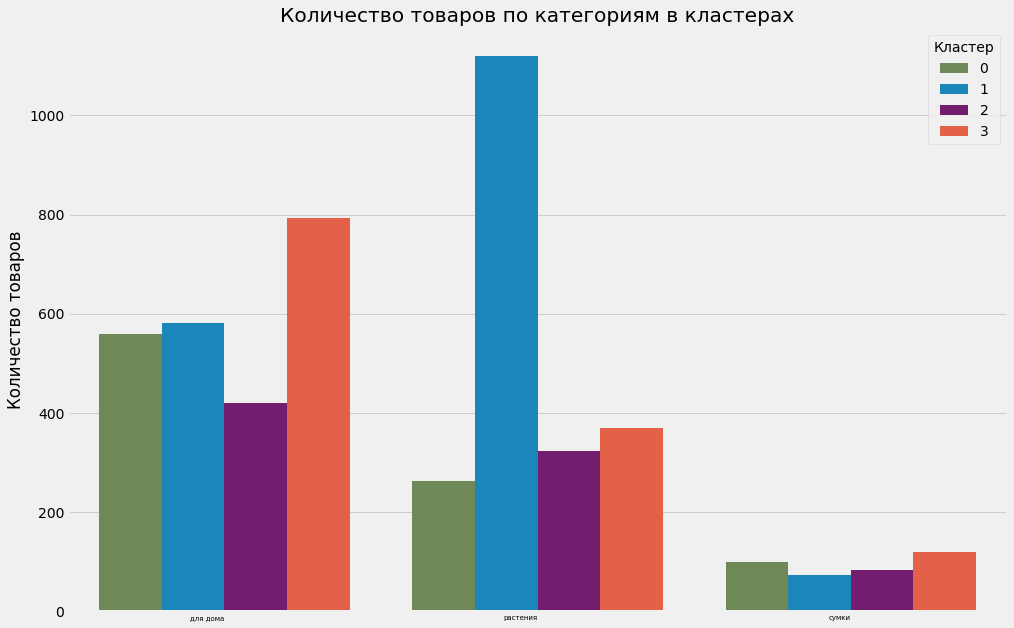

In [136]:
plt.figure(figsize=(15, 10))
sns.countplot(data=clean_data, x='product_category', hue='cluster', palette=['C3', 'C12','C5','C7'], \
              order=clean_data['product_category'].value_counts().index)
plt.xticks(rotation_mode='anchor', ha='right', fontsize=7)
plt.title('Количество товаров по категориям в кластерах')
plt.xlabel('')
plt.ylabel('Количество товаров')
plt.legend(title='Кластер')
plt.show()

В первом кластере больше больше всего товаров для дома.

Во втором кластере больше всего растений.

В третем кластере так же больше всего товаров для дома.

В 4м кластере больше всего товаров для дома.

Показатели в кластерах по категории "сумки" практически одинаково низкие во всех.



### Рассмотрим количество товаров по сезонам к кластерах.



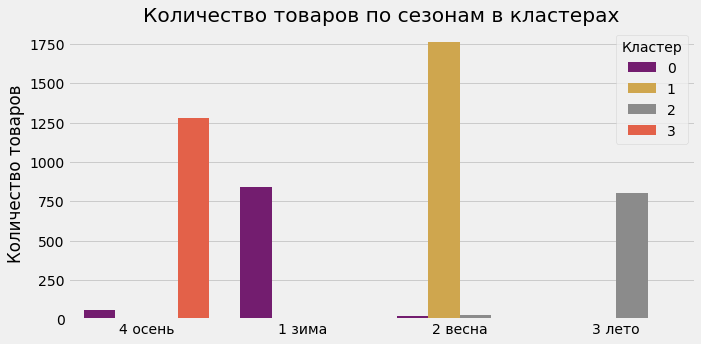

In [137]:
plt.figure(figsize=(10, 5))
sns.countplot(data=clean_data, x='season', hue='cluster', palette=['C29', 'C8', 'C40','C7'])
plt.title('Количество товаров по сезонам в кластерах')
plt.xlabel('')
plt.ylabel('Количество товаров')
plt.legend(title='Кластер')
plt.show()

1й кластер - зимний, 2й - весенний, 3й - летний и 4й - осенний. По количеству товаров второй кластер лидирует.


### Построим heatmap по количеству уникальных заказов и количеству товаров  в категориях в разрезе по кластерам и сезонам.

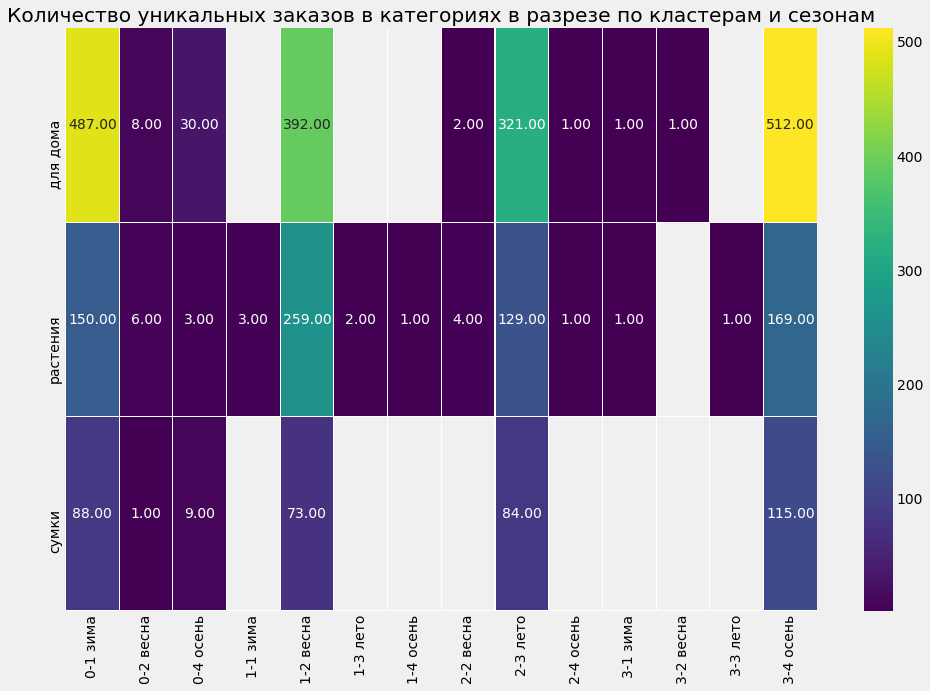

In [138]:
unique_orders = clean_data.pivot_table(
    index='product_category', columns=['cluster', 'season'], values='order_id', aggfunc='nunique')
plt.figure(figsize=(15, 10))
sns.heatmap(unique_orders, annot=True, fmt='.2f', linewidth=0.1, cmap='viridis')
plt.title('Количество уникальных заказов в категориях в разрезе по кластерам и сезонам')
plt.xlabel('')
plt.ylabel('')
plt.show()

Первый кластер очень часто заказывает зимой товары для дома, и совсем не заказывает летом.

Второй кластер заказывает только весной и в основном товары для дома.

Третий кластер - заказывает только летов, в большинстве случаев товары для дома и растения.

Четвертый кластер - только только осеньюи в основном товары для дома.

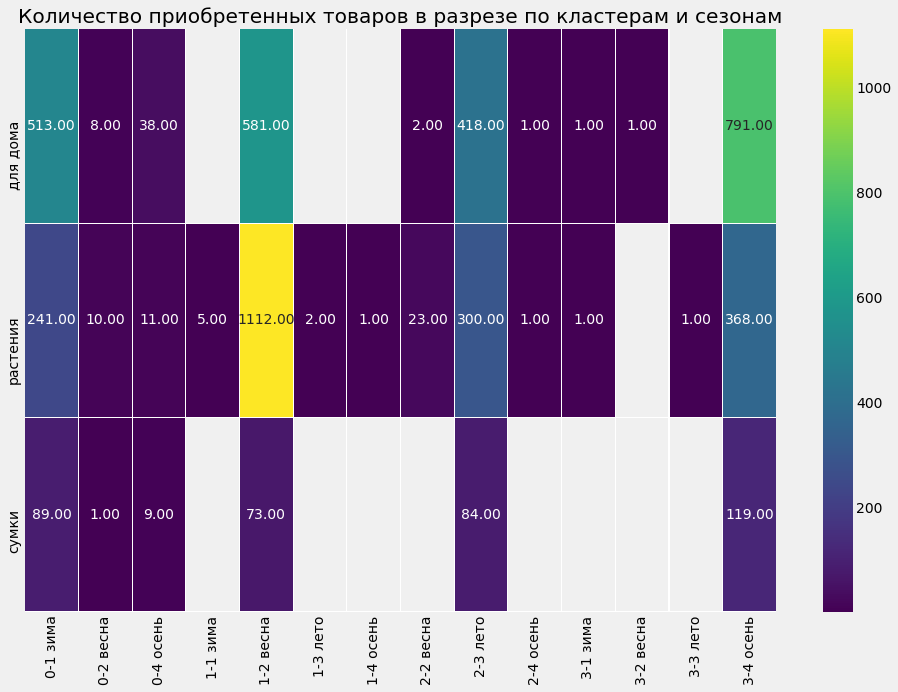

In [139]:
products_sold = clean_data.pivot_table(
    index='product_category', columns=['cluster', 'season'], values='product', aggfunc='count')
plt.figure(figsize=(15, 10))
sns.heatmap(products_sold, annot=True, fmt='.2f', linewidth=0.1, cmap='viridis')
plt.title('Количество приобретенных товаров в разрезе по кластерам и сезонам')
plt.xlabel('')
plt.ylabel('')
plt.show()

<div class="alert alert-warning"; style="border-left: 7px solid gold">
<b>⚠️ Комментарий ревьюера, ревью 1</b> 

Данный график довольно тяжело понимать. 
   
    
Возможно стоит разделить на отдельные графики для каждого кластера. Нам ведь необязательно сравнивать кластеры по сезонности и категориям между собой. Мы просто изучаем тренды внутри каждого отдельного кластера.

По количеству приобретенных товаров 1й кластер очень много зимой заказывают товары для дома.

Второй кластер весной покупают растения в больших количествах и много товаров для дома.

Третий кластер заказыввает болше сумок, чем другие сегменты, так же много товаров для дома.

### Рассмотрим суммарную выручку по кластерам и сезонам.

In [140]:
season_revenue = clean_data.pivot_table(index=['season', 'cluster'], values=['customer_id', 'revenue', 'order_id'], aggfunc={
    'customer_id':'nunique', 'revenue':'sum', 'order_id':'nunique'}).reset_index()

In [141]:
season_revenue.groupby(['season', 'cluster']).agg({'revenue':'sum'})

revenue
season  cluster           
1 зима  0         880726.0
        1            660.0
        3            641.0
2 весна 0          10563.0
        1         789389.0
        2           6805.0
        3            194.0
3 лето  1            269.0
        2         619466.0
        3           1034.0
4 осень 0          53220.0
        1            149.0
        2           1222.0
        3        1040360.0

По выручке лето провальное.

In [142]:
category_revenue = clean_data.query('date< "2019-10-01"').pivot_table(index=['product_category', 'cluster'], \
                                          values=['customer_id', 'revenue', 'order_id'], aggfunc={
    'customer_id':'nunique', 'revenue':'sum', 'order_id':'nunique'}).reset_index()

In [143]:
category_revenue.groupby(['product_category', 'cluster']).agg({'revenue':'sum'})

revenue
product_category cluster          
для дома         0        644009.0
                 1        415875.0
                 2        405646.0
                 3        617553.0
растения         0         89266.0
                 1        201484.0
                 2         80937.0
                 3         63969.0
сумки            0        211234.0
                 1        172959.0
                 2        139688.0
                 3        155588.0

При рассмотрении выручки по категориям, видим, что почти все кластеры предпочитают товары для дома, так как эта категоирия самая крупная. Но так же видим неплохие показатели по продаже растений для второго кластера и по сумкам для первого.

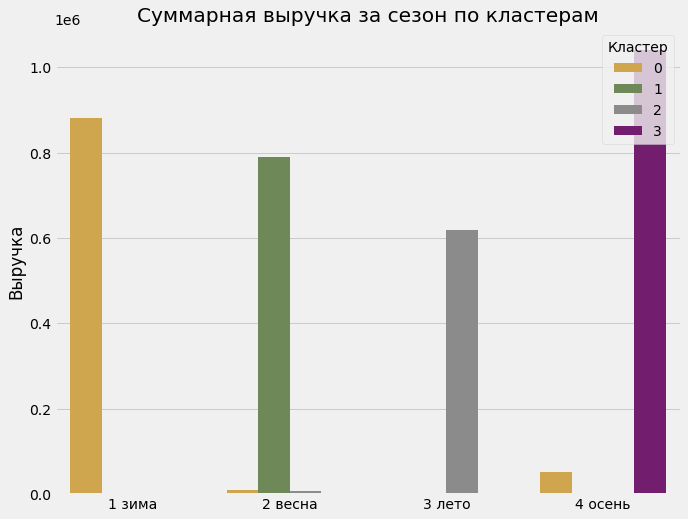

In [144]:
plt.figure(figsize=(10, 8))
sns.barplot(data=season_revenue, y='revenue', x='season', hue='cluster', palette=['C2', 'C3', 'C40', 'C5'])
plt.xlabel('')
plt.ylabel('Выручка')
plt.title('Суммарная выручка за сезон по кластерам')
plt.legend(title='Кластер')
plt.show()

Опять же видим, что лето провальное. Осенью самая хорошая выручка, ее делает 4й кластер.

Далее рассмотрим выручку по категориям.

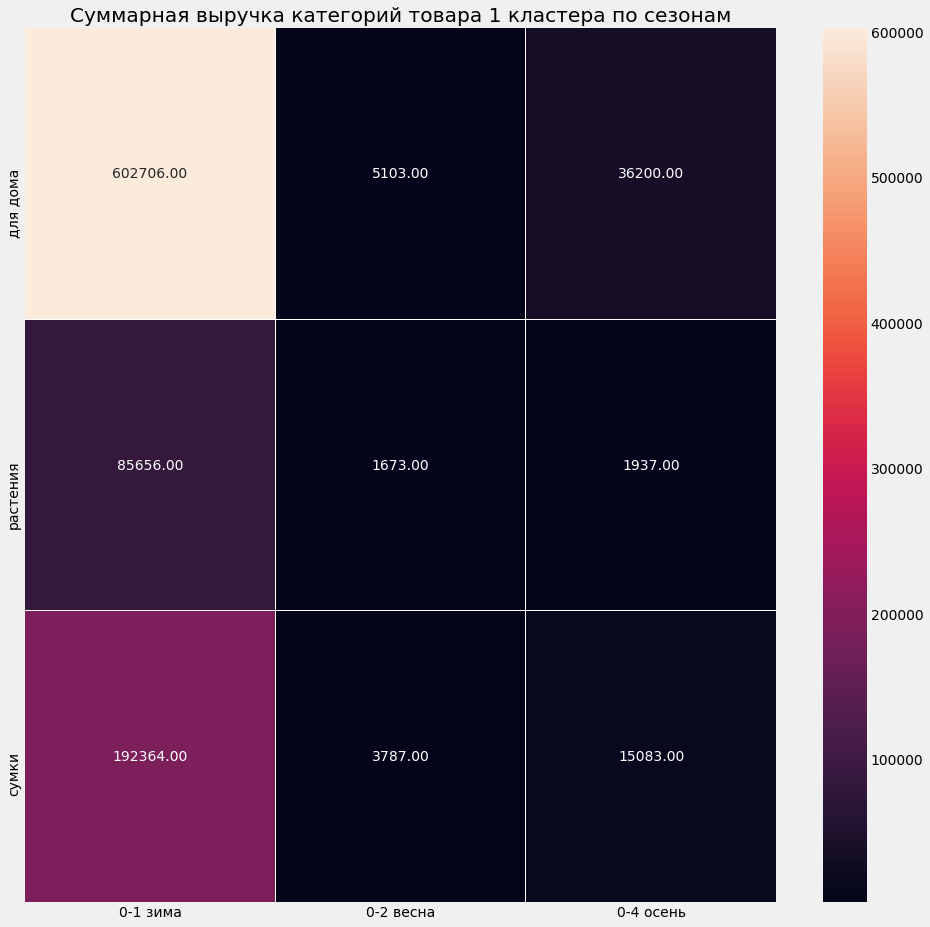

In [145]:
category_revenue = clean_data.query('cluster == 0').pivot_table(
    index='product_category', columns=['cluster', 'season'], values='revenue', aggfunc='sum')
plt.figure(figsize=(15, 15))
sns.heatmap(category_revenue, annot=True, fmt='.2f', linewidth=0.2)
plt.title('Суммарная выручка категорий товара 1 кластера по сезонам')
plt.xlabel('')
plt.ylabel('')
plt.show()

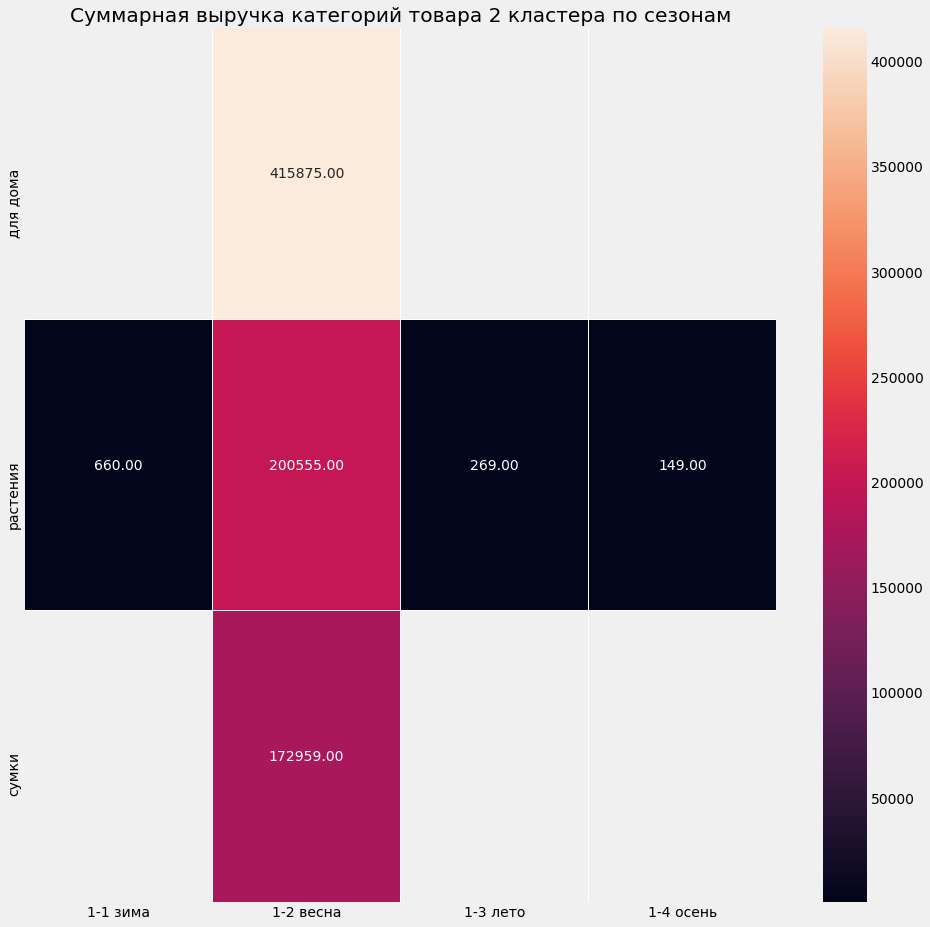

In [146]:
category_revenue = clean_data.query('cluster == 1').pivot_table(
    index='product_category', columns=['cluster', 'season'], values='revenue', aggfunc='sum')
plt.figure(figsize=(15, 15))
sns.heatmap(category_revenue, annot=True, fmt='.2f', linewidth=0.2)
plt.title('Суммарная выручка категорий товара 2 кластера по сезонам')
plt.xlabel('')
plt.ylabel('')
plt.show()

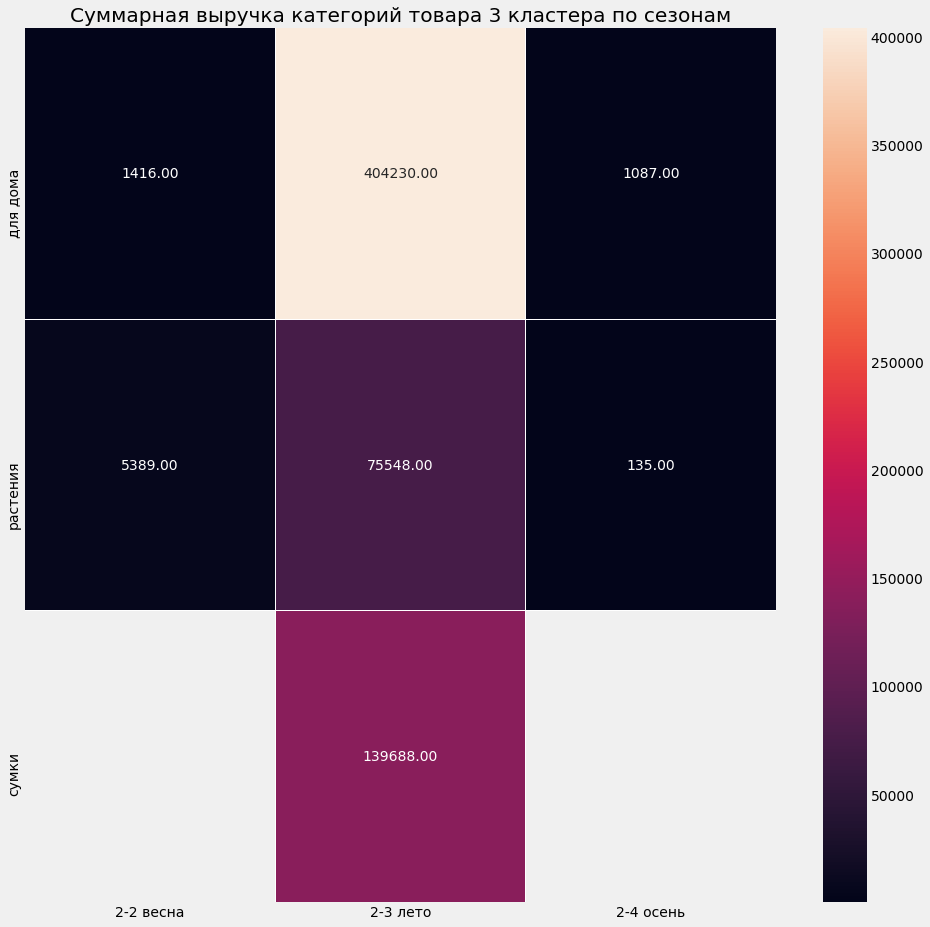

In [147]:
category_revenue = clean_data.query('cluster == 2').pivot_table(
    index='product_category', columns=['cluster', 'season'], values='revenue', aggfunc='sum')
plt.figure(figsize=(15, 15))
sns.heatmap(category_revenue, annot=True, fmt='.2f', linewidth=0.2)
plt.title('Суммарная выручка категорий товара 3 кластера по сезонам')
plt.xlabel('')
plt.ylabel('')
plt.show()

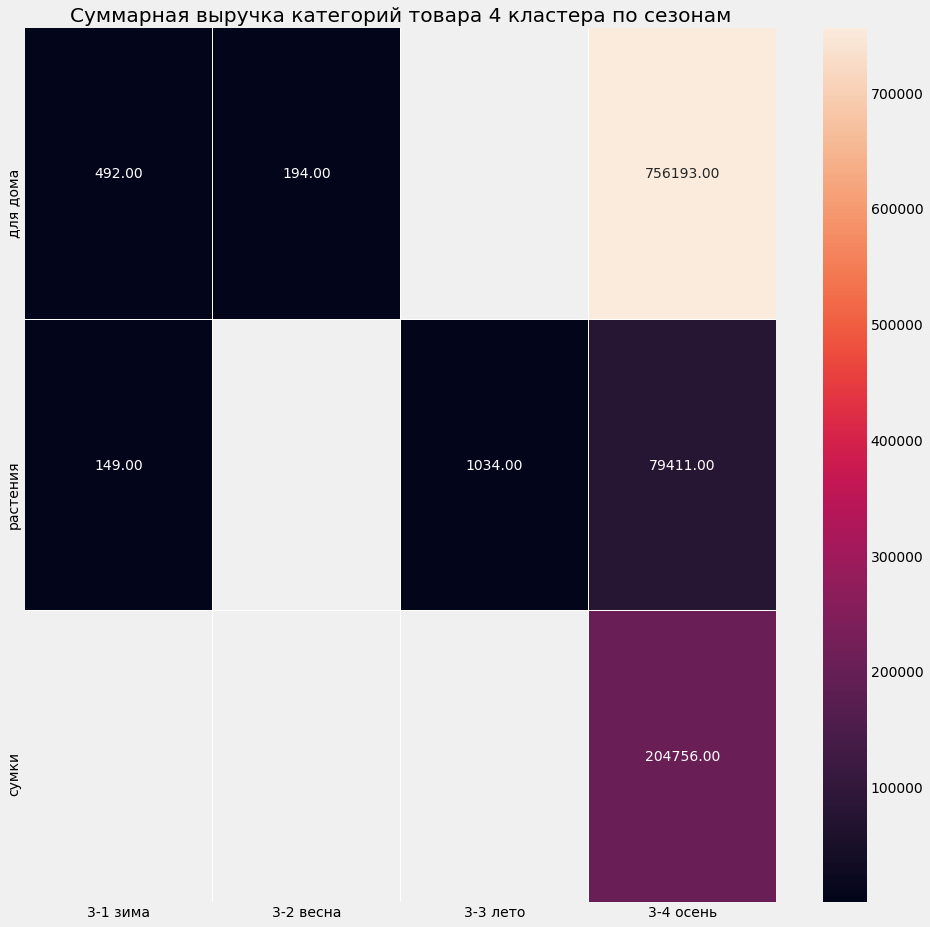

In [148]:
category_revenue = clean_data.query('cluster == 3').pivot_table(
    index='product_category', columns=['cluster', 'season'], values='revenue', aggfunc='sum')
plt.figure(figsize=(15, 15))
sns.heatmap(category_revenue, annot=True, fmt='.2f', linewidth=0.2)
plt.title('Суммарная выручка категорий товара 4 кластера по сезонам')
plt.xlabel('')
plt.ylabel('')
plt.show()

Товары для дома для первого и четвертого кластера - золотая жила магазина. Растения во втором кластере так же приносят хорошие деньги, тем более, если учитывать, что большинство растений из дешевой категории товаров.

### Рассмотрим динамику среднего чека по кластерам и сезону.

In [149]:
avg_check = clean_data.groupby('season').agg({'revenue':'sum', 'order_id':'nunique'})
avg_check['avg'] = avg_check['revenue'] / avg_check['order_id']

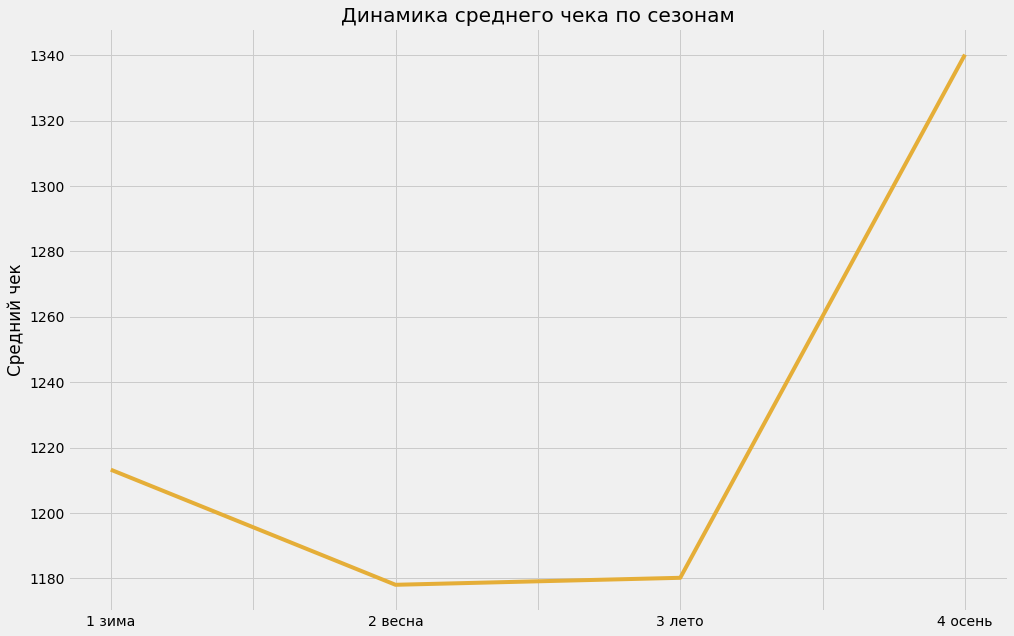

In [150]:
avg_check.plot(figsize=(15, 10), y='avg', color='C44', legend=False)
plt.title('Динамика среднего чека по сезонам')
plt.xlabel('')
plt.ylabel('Средний чек')
plt.show()

По сезонам очевидно, средний чек начинает расти осенью, падает летом.

In [151]:
avg_cluster = clean_data.groupby(['season', 'cluster']).agg(
    {'revenue':'sum','order_id':'nunique'}).reset_index(level='cluster')
avg_cluster['revenue_per_order'] = avg_cluster['revenue'] / avg_cluster['order_id']

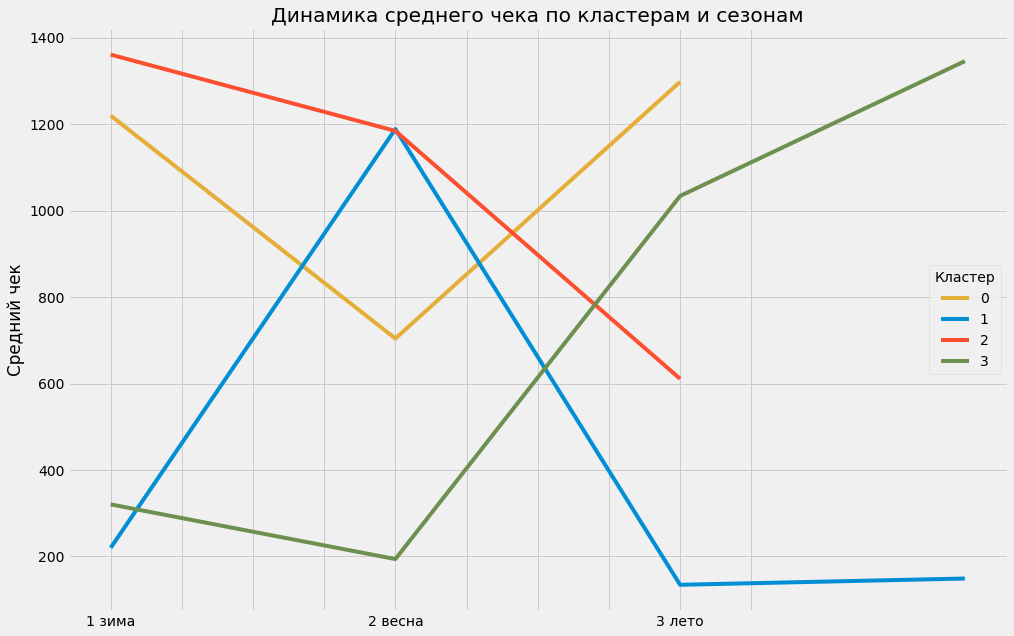

In [152]:
plt.figure(figsize=(15, 10))
avg_cluster[avg_cluster['cluster'] == 0]['revenue_per_order'].plot(color='C44', label=0)
avg_cluster[avg_cluster['cluster'] == 1]['revenue_per_order'].plot(color='C66', label=1)
avg_cluster[avg_cluster['cluster'] == 2]['revenue_per_order'].plot(color='C55', label=2)
avg_cluster[avg_cluster['cluster'] == 3]['revenue_per_order'].plot(color='C33', label=3)

plt.legend(title='Кластер')
plt.title('Динамика среднего чека по кластерам и сезонам')
plt.ylabel('Средний чек')
plt.xlabel('')
plt.show()

In [153]:
avg_cluster = clean_data.groupby(['dt', 'cluster']).agg(
    {'revenue':'sum','order_id':'nunique'}).reset_index(level='cluster')
avg_cluster['revenue_per_order'] = avg_cluster['revenue'] / avg_cluster['order_id']

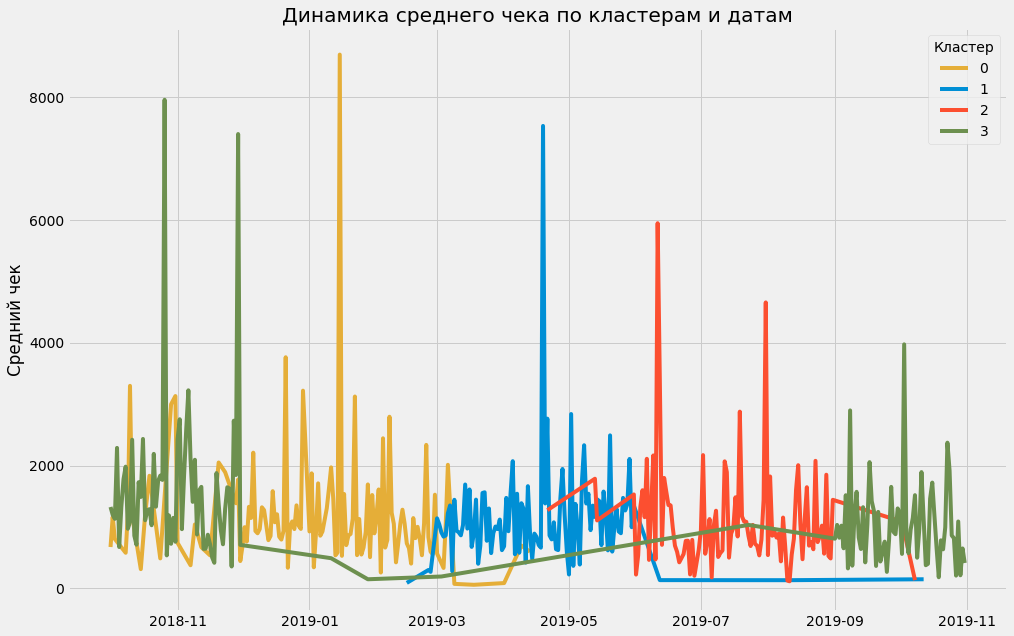

In [154]:
plt.figure(figsize=(15, 10))
avg_cluster[avg_cluster['cluster'] == 0]['revenue_per_order'].plot(color='C44', label=0)
avg_cluster[avg_cluster['cluster'] == 1]['revenue_per_order'].plot(color='C66', label=1)
avg_cluster[avg_cluster['cluster'] == 2]['revenue_per_order'].plot(color='C55', label=2)
avg_cluster[avg_cluster['cluster'] == 3]['revenue_per_order'].plot(color='C33', label=3)

plt.legend(title='Кластер')
plt.title('Динамика среднего чека по кластерам и датам')
plt.ylabel('Средний чек')
plt.xlabel('')
plt.show()

Опять же наблюдаем сезонность. Так же можем определить, что клиенты первого кластера не делали заказы последние пол года.
 

### Рассмотрим прибыльность и какие товары покупают чаще всего, в какое время года.

In [155]:
category = clean_data['product_category'].unique()
for i in category:
    display(i, clean_data[clean_data['product_category'] == i].groupby('product').agg(
        {'order_id':'nunique', 'quantity':'sum', 'revenue':'sum',}).sort_values(by='revenue', ascending=False).head(5))

'растения'

,order_id,quantity,revenue
product,,,
Спатифиллум Шопен d-12 см,2,46,11512.0
Пеларгония зональная диам. 12 см сиреневый полумахровый,52,63,10780.0
Пеларгония розебудная Red Pandora укорененный черенок,64,79,10655.0
Пеларгония зональная диам. 12 см красная махровая,21,63,10514.0
Эвкалипт Гунни d-17 см h-60 см,6,6,9866.0


'для дома'

,order_id,quantity,revenue
product,,,
Простынь вафельная 200х180 см WELLNESS RW180-01 100% хлопок,2,30,53232.0
Вешалки мягкие для деликатных вещей 3 шт шоколад,2,335,49596.0
Муляж ЯБЛОКО 9 см красное,6,618,32702.0
Набор ножей Attribute CHEF 5 предметов AKF522,1,64,29248.0
"Урна уличная ""Гео"", Hobbyka/Хоббика, 59*37,5см, сталь",1,5,24370.0


'сумки'

,order_id,quantity,revenue
product,,,
Сумка-тележка 2-х колесная Gimi Argo синяя,47,47,50405.0
Тележка багажная DELTA ТБР-22 синий грузоподъемность 20 кг сумка и 50 кг каркас РОССИЯ,3,59,33992.0
"Сумка-тележка хозяйственная Andersen Scala Shopper Plus, Lini, синяя 133-108-90",5,5,28045.0
Сумка-тележка 3-х колесная Gimi Tris Floral синяя,7,7,18893.0
"Сумка-тележка хозяйственная Andersen Treppensteiger Scala Shopper, Hera, черная 119-004-80",3,3,18560.0


Вывели топ-5 товаров по категориям:
 * *растения* - Пеларгония в трех вариациях, Спатифиллум, Эвкалипт 
 * *для дома* - Простынь вафельная, Сумка-тележка, вешалки мягкие..
 * *сумки* - Сумка-тележка 2-х колесная, Тележка багажная DELTA, Сумка-тележка 3-х колесная, ..

В таблицах можно увидеть так же выручку по данным товарам.

In [156]:
season = clean_data['season'].unique()

for i in season:
    display(i, clean_data[clean_data['season'] == i].groupby('product').agg(
        {'order_id':'nunique', 'quantity':'sum', 'revenue':'sum'}).sort_values(by='revenue', ascending=False).head(5))

'4 осень'

,order_id,quantity,revenue
product,,,
Набор ножей Attribute CHEF 5 предметов AKF522,1,64,29248.0
"Урна уличная ""Гео"", Hobbyka/Хоббика, 59*37,5см, сталь",1,5,24370.0
Муляж ЯБЛОКО 9 см красное,5,318,17402.0
Сумка-тележка 2-х колесная Gimi Argo синяя,13,13,13941.0
Сумка-тележка хозяйственная Rolser IMX005 marengo Logic DOS+2 серая,2,2,12014.0


'1 зима'

,order_id,quantity,revenue
product,,,
Простынь вафельная 200х180 см WELLNESS RW180-01 100% хлопок,2,30,53232.0
Тележка багажная DELTA ТБР-22 синий грузоподъемность 20 кг сумка и 50 кг каркас РОССИЯ,2,58,33355.0
Сумка-тележка 2-х колесная Gimi Argo синяя,16,16,16898.0
Мусорный контейнер Hailo BigBin Swing 45 0845-010 45 л хром,1,3,16536.0
Спатифиллум Шопен d-12 см,1,45,11250.0


'2 весна'

,order_id,quantity,revenue
product,,,
Одеяло Wellness T142 белое темостеганое 140х205 см чехол 100% полиэстер 200 г/м 4690659000306,1,10,15680.0
Муляж ЯБЛОКО 9 см красное,1,300,15300.0
Салфетка Protec Textil Polyline 30х43 см Аметист белая 6230,2,74,14386.0
"Наматрацник Natures Бархатный бамбук ББ-Н-1-2 односпальный, 100% хлопок, стеганый 90х200 см, с резинкой по углам, белый",1,12,14196.0
"Сумка-тележка хозяйственная Andersen Scala Shopper Plus, Lini, синяя 133-108-90",2,2,12298.0


'3 лето'

,order_id,quantity,revenue
product,,,
Вешалки мягкие для деликатных вещей 3 шт шоколад,2,335,49596.0
Гладильная доска НИКА BLUES 124х46 см 5757,5,5,12635.0
Скатерть круглая d-175 см 50% полиэстер 50% хлопок белая Wellness MLd-187-Эстель*01,1,10,11400.0
Сумка-тележка 2-х колесная Gimi Argo синяя,9,9,9783.0
"Сумка-тележка хозяйственная Andersen Scala Shopper, Lini, синяя 112-108-90",2,2,9148.0


Топ-5 по сезонам:
* осень - Набор ножей, Урна уличная, Муляж ЯБЛОКО, Сумка-тележка, ..
* зима - Простынь вафельная, Тележка багажная, Сумка-тележка, ..
* весна - Одеяло Wellness, Муляж ЯБЛОКО, Салфетка Protec, ..
* лето - Вешалки мягкие, Гладильная доска, Скатерть круглая, ..

Так же в таблтцах можно увидеть выручку по товарам.

### Рассмотрим отдельно показатели за последний месяц - октябрь 2019 года.

In [157]:
oct_2019 = clean_data.query('date > "2019-10-01"')

In [158]:
oct_2019.groupby('product').agg({'order_id': 'nunique', 'quantity':'sum', 'revenue':'sum'})\
.sort_values(by='revenue', ascending=False)

,order_id,quantity,revenue
product,,,
"Сумка-тележка хозяйственная Rolser Jet Joy синяя, JET027 azul JOY",2,2,7950.0
Стремянка 7 ступенчатая Hailo 8040-707 XXL 13 см алюминиевая с лотком для инструментов,1,1,7724.0
Урна уличная стальная Юпитер 02.012.0 38х38х60 см,1,1,6899.0
Сумка-тележка хозяйственная Rolser MNB012 azul Logic RG,1,1,6600.0
Сумка-тележка хозяйственная Rolser IMX004 negro Logic RG черная,1,1,6075.0
...,...,...,...
Муляж Баклажан 18 см,1,1,59.0
Искусственный цветок Гербера пластиковая розовая,1,2,58.0
Искусственный цветок Подснежник пластиковый белый,1,1,37.0


In [159]:
print('Количество уникальных заказов в октябре 2019:', oct_2019['order_id'].nunique())

Количество уникальных заказов в октябре 2019: 196


In [160]:
print('Выручка в октябре 2019:', oct_2019['revenue'].sum())

Выручка в октябре 2019: 206490.0


In [161]:
oct_2018 = clean_data.query('date < "2018-10-31"')

In [162]:
print('Выручка в октябре 2018:', oct_2018['revenue'].sum())

Выручка в октябре 2018: 342709.0


In [163]:
print('Количество уникальных заказов в октябре 2018:', oct_2018['order_id'].nunique())

Количество уникальных заказов в октябре 2018: 231


В целом показатели за последний месяц средние, но кол-во уникальных заказов и выручка меньше, чем в октябре 2018 года.

### Средний чек, общая выручка и среднее количество заказов в месяц по кластерам.

In [164]:
clean_data.groupby('cluster').agg({'revenue':'sum'})

,revenue
cluster,
0,944509.0
1,790467.0
2,627493.0
3,1042229.0


Общая выручка по кластерам : 1 - 944509, 2 - 790467, 3 - 627493, 4 - 1042229

In [165]:
avg_by_clast = clean_data.groupby('cluster').agg({'revenue':'sum' , 'order_id': 'nunique'})
avg_by_clast['avg_check'] = avg_by_clast['revenue']/avg_by_clast['order_id']

In [166]:
avg_by_clast.round()

,revenue,order_id,avg_check
cluster,,,
0,944509.0,777,1216.0
1,790467.0,670,1180.0
2,627493.0,529,1186.0
3,1042229.0,777,1341.0


Средний чек в первом и 4м кластере близки 1216 и 1341 соответственно, во втором и третьем почти равны - 1180 и 1186.

Среднее количество заказов одинакомо между 1м и 4м кластером.

In [167]:
avg_order_count =  clean_data.groupby('cluster').agg({ 'order_id': 'nunique'})
avg_order_count['avg'] = avg_order_count['order_id']/13

In [168]:
avg_order_count['avg'].round()

cluster
0    60.0
1    52.0
2    41.0
3    60.0
Name: avg, dtype: float64

Среднее количество заказов в месяц для первого кластера - 60, для второго - 52, для третьего -41, для четвертого - 60.

### Рассмотрим ценовые категории товаров в разрезе кластеров.

In [169]:
price_clust_category = clean_data.pivot_table(index='cluster', columns='price_category', \
                                  values='order_id', aggfunc='nunique').sort_values(by='cluster',
                                                                                   ascending=False).reset_index()

In [170]:
fig = px.bar(price_clust_category, x='cluster', y=['дешевые','средние','недорогие','дорогие'],
       title="Количество товаров в каждом кластере по ценовой категории", 
            height=500)
fig.update_layout (xaxis_title = 'Кластер', yaxis_title = 'Количество товаров', legend_title='Ценовая категория')
update_xtitle = ('Кластер')
update_xtitle = ('Количество товаров')
fig.show()

Распределение здесь вполне предсказуемо, т.к. 84% товаров относятся к дешевым, стоимость менее 500 рублей.

### Выводы по сегментации и анализу сегментов:

Создали датафрэйм users_fich, который отражает общее и среднее количество заказов за весь период, общее и среднее количество наименований товара, среднюю сумму, а так же общее количество заказов по временам года и категорям для КАЖДОГО УНИКАЛЬНОГО ПОЛЬЗОВАТЕЛЯ.

С помощью машинного обучения выделили 4 кластера. 

С помощью ttтеста выявили, что между кластерами нет статистической разницы как в показателях среднего чека, так и в показателях выручки. Мы провели 6 проверок стат гипотез. Повышать уровень альфа до 0.1 не имеет смысла из-за повышения вероятности ложнопозитивного результата. Исходя из поправки  Бонферрони - скорректированный уровень значимости 0,008. Минимальное значение p_value в наших рассчетах - 0,07, что выше скорректированного уровня стат значимости, поэтому повторная проверка не нужна.

*1й кластер* -  612 пользователей, зимний кластер. Неплохие показатели по продаже сумок, учитывая малое количество товаров этой категории, тем не менее товары для дома этого кластера - "золотая жила". Выяснили, что клиенты первого кластера не делали заказы последние пол года. Общая выручка - 944509, среднее количество заказов в месяц - 60, средний чек - 1216.

*2й кластер* -  602 пользователя, по количеству приеобретенных товаров  лидирует, а именно хорошие показатели по продаже растений (вспомним, что почти все растения относятся к категории дешевых товаров). Так же определили, что это "весенний" кластер, т.е. все практически все покупки были совершены весной. Общая выручка - 790467, среднее количество заказов в месяц -52, средний чек - 1180.

*3й кластер* - 489 пользователей, летний кластер, а значит приносящий наименьший доход, к сожалению. Общая выручка - 627493, среднее количество заказов в месяц - 41, средний чек - 1186. Если обратить внимание на средний чек, в целом он не так и плох.

*4й кластер* - 689 пользователей, кластер сезона "осень", наиболее прибыльный по выручке и среднему чеку. Так же, как и для первого кластера, товары категории для дома - золотая жила. Общая выручка - 1042229, средний чек - 1341, среднее количество заказов в месяц - 60.

Рассмотрели в отдельности октябрь 2019 и октябрь 2018 года. Отметим, что общая выручка за последний месяц - 206490, а в октябре 2018 - 342709, количество уникальных заказов за последний месяц -196, а за первый - 231. Можем сделать вывод, что показатели прибыльности снизились.


Самые прибыльные товары по категориям:

* растения - Пеларгония в трех вариациях, Спатифиллум, Эвкалипт

* для дома - Простынь вафельная, Сумка-тележка, ..

* сумки - Сумка-тележка 2-х колесная, Тележка багажная DELTA, Сумка-тележка 3-х колесная, ..

Самые прибыльные товары по сезонам:

* осень - Набор ножей, Урна уличная, Сумка-тележка, ..

* зима - Простынь вафельная, Тележка багажная, Сумка-тележка, ..

* весна - Одеяло Wellness, Муляж ЯБЛОКО, Салфетка Protec, ..

* лето - Вешалки мягкие, Гладильная доска, Скатерть круглая, ..

## Выводы и рекомендации.

Очистили данные от выбросов и дубликатов. Уникальных клиентов 2394, 2330 уникальных товара, уникальных заказов 2755. Располагаем данными с 31-10-2018 по 01-10-2019.

Распределили товары по ценовым категориям: преобладают "дешевые" товары, товары средней и дорогой ценовой категории - всего лишь 5,5%. 

По очищенным данным общая выручка магазина за весь период - 3404698 рублей, средняя выручка с покупателя - 1423 рублей, средний чек - 1237 рублей, средняя выручка в месяц - 261900 р.

Распределили товары на три категории:

 * Растения - 728 заказов, практически все относятся к дешевым товарам. Наиболее популярные позиции - Пеларгония в трех вариациях, Спатифиллум, Эвкалипт.
 * Для дома - 1755 заказ, наиболее популярные позиции - простынь вафельная, сумка-тележка.
 * Сумки - 370 заказов, наиболее популярные - сумка-тележка 2-х колесная, тележка багажная DELTA.
 
Выделили 4 кластера (получилось четкое разделение профилей пользователей по сезонам): 

* 1й кластер -  зима. 612 пользователей, зимний кластер. Неплохие показатели по продаже сумок, учитывая малое количество товаров этой категории, тем не менее товары для дома этого кластера - "золотая жила". Выяснили, что клиенты первого кластера не делали заказы последние пол года. Общая выручка - 944509, среднее количество заказов в месяц - 60, средний чек - 1216.

* 2й кластер - весна. 602 пользователя, по количеству приеобретенных товаров  лидирует, а именно хорошие показатели по продаже растений (вспомним, что почти все растения относятся к категории дешевых товаров). Так же определили, что это "весенний" кластер, т.е. все практически все покупки были совершены весной. Общая выручка - 790467, среднее количество заказов в месяц -52, средний чек - 1180.


* 3й кластер - лето. 489 пользователей, летний кластер, а значит приносящий наименьший доход, к сожалению. Общая выручка - 627493, среднее количество заказов в месяц - 41, средний чек - 1186. Если обратить внимание на средний чек, в целом он не так и плох.

* 4й кластер - осень. 689 пользователей, кластер сезона "осень", наиболее прибыльный по выручке и среднему чеку. Так же, как и для первого кластера, товары категории для дома - золотая жила. Общая выручка - 1042229, средний чек - 1341, среднее количество заказов в месяц - 60.


Зимой и осенью стоит обратить внимание на категорию "для дома". В холодное время года люди больше сосредоточны на быте, домашнем уюте, соответсвенно покупают больше для дома, например, аксессуары или другие предметы интерьера.

Весной наиболее популярны растения, тоже сезонность - рассада и тд. Но отмечу, что практически все растения стоимостью менее 500 рублей, из-за чего маленькие выручки.

Летом больше востребованы товары категории сумки, но их в ассортементе не так много, да и прайсы большие. 


С помощью ttтеста выявили, что между кластерами нет статистической разницы как в показателях среднего чека, так и в показателях выручки. Мы провели 6 проверок стат гипотез. Повышать уровень альфа до 0.1 не имеет смысла из-за повышения вероятности ложнопозитивного результата. Исходя из поправки  Бонферрони - скорректированный уровень значимости 0,008. Минимальное значение p_value в наших рассчетах - 0,07, что выше скорректированного уровня стат значимости, поэтому повторная проверка не нужна.

Так же рассмотрели в отдельности октябрь 2019 и октябрь 2018 года. Отметим, что общая выручка за последний месяц - 206490, а в октябре 2018 - 342709, количество уникальных заказов за последний месяц - 196, а за первый - 231. Можем сделать вывод, что показатели прибыльности снизились.


**Рекомендации:**

1. Для клиентов 1го кластера рекомендую делать спец предложения по товарам для дома зимой.
2. Для клиентов 2го кластера рекомендую делать спец предложения по растениям весной.
3. Для клиентов 3го кластера рекомендую делать спец предложения по товарам категории сумки летом.
4. Для клиентов 4го кластера рекомендую делать спец предложения по товарам категории для дома осенью.
5. Так же стоит обратить внимание, что показатели прибыльности немного снизились к октябрю 2019 года, возможно стоит добавить новые позиции товаров, чтобы привлечь новых покупателей.
6. В целом не стоит пренебрегать сезонностью, даже из логических суждений можно сделать выводы о прибыльности той или иной категории товаров в определенное время года.

Ссылка на презентацию :  https://disk.yandex.ru/i/bRHWU0n75KX5jA